In [1]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import folktables
import numpy as np
import pickle
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
from bestLS_hindsight_together import *
from oridge_alwaysactive_implementable import *


from folktables.load_acs import state_list

ModuleNotFoundError: No module named 'OnlineRidgeRiver'

In [ ]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  N = len(Anh.cuml_regret_curve)
  for gnum in range(N):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end}, Anh end regret {Anh_end}, \n
    Anh better {Anhst} ''')
    print(f'''Oridge regret - Anh regret implementables {oridge_end - Anh_end}''')
    # if Anhst == "Yes":
    #   print(f''' Delta / larger % {100 * (oridge_end - Anh_end) / abs(oridge_end)} ''')
    # else:
    #   print(f''' Delta / larger % {100 * (Anh_end - oridge_end) / abs(Anh_end)} ''')
    rel_diff = 2 * abs(oridge_end - Anh_end) / (abs(oridge_end) + abs(Anh_end))
    print(f'''Relative difference percent {100 * rel_diff}''')  # https://en.wikipedia.org/wiki/Relative_change_and_difference
    # print(f'''Anh is {Anh_end / oridge_end} fraction of Oridge regret''')
    # print(f'''Anh is {100 * (1 - (Anh_end / oridge_end))} % smaller than Oridge regret''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups') # caught a bug here!

In [4]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, TargetEncoder, StandardScaler, OneHotEncoder
def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def ordinal_encoder(df, cols): # similar to label encoder which only works for targets?
    '''
    Encode categorical into 0 ... n-1
    '''
    df_new = df.copy()
    ordinal_enc = OrdinalEncoder()
    df_new[cols] = ordinal_enc.fit_transform(df_new[cols])
    return df_new

def oh_sklearn(df, cols):
    pass
    # Issues with this operation as it doesnt preseve number of columns etc, the dummies method below works
    # df_new = df.copy()
    # oh_enc = OneHotEncoder()
    # df_new[cols] = oh_enc.fit_transform(df_new[cols])
    # return df_new

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def target_encoder(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new

def target_encoder2(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new, enc_auto

In [23]:
data_fil.sample(frac = 1, random_state = 21)

,OCCP,WKHP,AGEP,SCHL,ST,JWTRNS,DRAT,COW,SEX,RELSHIPP,POBP,ENG,MAR,RAC1P,PINCP
77964,4220,15.0,19.0,19,6,11,0,2,1,38,24,0,5,1,9550.0
62328,2300,39.0,26.0,18,5,1,0,1,2,20,5,0,1,1,25800.0
1233784,3602,40.0,87.0,16,42,11,0,1,1,20,42,0,2,1,80700.0
1297975,4140,20.0,20.0,16,45,0,0,1,2,26,45,0,5,2,130.0
1539878,4251,40.0,43.0,14,53,0,0,1,1,37,53,0,5,1,11200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590612,750,38.0,34.0,20,19,1,0,1,2,21,19,0,1,1,50000.0
65607,3930,25.0,72.0,19,5,1,4,1,1,20,5,0,1,1,49100.0
1176034,120,10.0,73.0,24,40,0,0,3,2,20,40,1,3,2,52200.0
691694,2545,40.0,60.0,21,24,1,0,3,2,21,42,0,1,1,30000.0


In [24]:
data_fil

,OCCP,WKHP,AGEP,SCHL,ST,JWTRNS,DRAT,COW,SEX,RELSHIPP,POBP,ENG,MAR,RAC1P,PINCP
0,4760,30.0,19.0,18,1,0,0,2,2,38,53,0,5,1,8000.0
1,4640,40.0,20.0,19,1,1,0,1,1,38,13,0,5,2,6300.0
2,5240,18.0,19.0,18,1,0,0,2,2,38,22,0,5,1,6200.0
3,4220,6.0,34.0,19,1,12,0,2,2,38,18,0,3,1,10800.0
4,2722,10.0,19.0,18,1,0,0,1,1,38,36,0,5,1,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,1430,40.0,40.0,21,72,1,0,1,2,20,72,2,5,9,80000.0
1630163,2205,40.0,47.0,22,72,1,0,2,1,20,72,3,1,9,60000.0
1630164,5740,40.0,46.0,21,72,1,0,4,2,21,72,0,1,9,18600.0
1630165,2634,30.0,22.0,21,72,11,0,6,1,25,72,2,5,9,12200.0


In [ ]:
1569188

In [20]:
di_temp = {}
di_temp['A_t'] = 1
di_temp['bls'] = 2
di_temp['Anh'] = 3
di_temp['oridge_implementable'] = 4
build_models('tp', 'tp', None, None, None, di_to_fill = di_temp)

In [21]:
di_temp

{'A_t': array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]),
 'bls': array([[1., 1.],
        [1., 1.]]),
 'Anh': array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]),
 'oridge_implementable': array([[1.]])}

In [9]:
type(data_fil)

pandas.core.frame.DataFrame

In [5]:
# Ira Globus code schema, and choosing only Significant features
ACSIncome = folktables.BasicProblem(
    features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'],
    target='PINCP',
    # target_transform=lambda x: x > 50000,    
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

cat_cols_sig = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'] # significant features from the earlier analysis

print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

for catg in cat_cols_sig:
    dataset[catg] = dataset[catg].astype(int)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [7]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
data_fil = data_incomeless200k
# top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
# data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

0.9625934030071766


# Start UD state by state, undropped

In [ ]:
print(cat_cols_sig)
df_oh = one_hot(data_fil, cat_cols_sig) # cat_cols_sig determined in 2buildmodels_withtargetencoding
print(df_oh.shape)

gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']
# A_tdf = df_oh[gnames]
# A_tdf['alwayson'] = 1
# A_t = A_tdf.to_numpy()

In [ ]:
# A_t = np.load('./onehot_encoded/nparrays/A_t12groups.npy')

In [ ]:
df_oh = df_oh.drop(cat_cols_sig, axis=1)
df_oh_scaled = numeric_scaler(df_oh, df_oh.columns)

In [ ]:
# df_oh_scaled.to_pickle('./onehot_encoded/dataframes/df_oh_scaled_includes_sensitive')

In [ ]:
df_oh_scaled

In [ ]:
# First we build the best sq loss for each group, using bestLShindsight together

# - first on the **undropped** race and sex columns **df_te_scaled** is used 

N = A_t.shape[1] #  12 groups 11 + 1 always active
# d = df_oh_scaled.shape[1] # d uses all 15 columns
# T = df_oh_scaled.shape[0] # ~1.5 million points
# print(N, d, T)

X_dat_oh_scaled = df_oh_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_oh_scaled = pd.DataFrame(df_oh_scaled['PINCP']) # picking up only the income column for the target

print(X_dat_oh_scaled.shape, y_dat_oh_scaled.shape)


In [ ]:
for ele in X_dat_oh_scaled_dropped.columns:
    if '_' not in ele:
        print(ele)

In [ ]:
# best square loss undropped
bls_undropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_undropped.update(A_t[t], X_dat_oh_scaled.iloc[[t]], y_dat_oh_scaled.iloc[t])

In [ ]:
bls_undropped.make_all_numpyarr()
import joblib
joblib.dump(bls_undropped, './onehot_encoded/models/bestsqloss/bls_oh_undropped.pkl')

In [ ]:
# best square loss dropped bug 
# (earlier didnt drop SEX, RAC1P, dt_temp was not inplace, now explciity)
# preparing the data to be ded into bls_dropped object
df_temp = data_fil.copy()
df_temp = df_temp.drop(['SEX', 'RAC1P'] , axis = 1) # remove RACE and SEX columns before one-hot encoding

cat_cols_dropped = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'RELSHIPP', 'POBP', 'ENG', 'MAR']
df_oh = one_hot(df_temp, cat_cols_dropped) # cat_cols_sig determined in 2buildmodels_withtargetencoding
print(df_oh.shape)

df_oh = df_oh.drop(cat_cols_dropped, axis=1)

print(df_oh.shape)

df_oh_dropped_scaled = numeric_scaler(df_oh, df_oh.columns) # does min max scaling

# df_oh_dropped_scaled.to_pickle('./onehot_encoded/dataframes/df_oh_scaled_drops_sensitive')

In [ ]:
X_dat_oh_scaled_dropped = df_oh_dropped_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_oh_scaled_dropped = pd.DataFrame(df_oh_dropped_scaled['PINCP']) # picking up only the income column for the target

In [ ]:
# N = A_t.shape[1] #  12 groups 11 + 1 always active
# d = df_oh_dropped_scaled.shape[1] # d uses all 15 columns
# T = df_oh_dropped_scaled.shape[0] # ~1.5 million points

# print(N, d, T)

In [ ]:
bls_dropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_dropped.update(A_t[t], X_dat_oh_scaled_dropped.iloc[[t]], y_dat_oh_scaled_dropped.iloc[t])

In [ ]:
import joblib
bls_dropped.make_all_numpyarr()
joblib.dump(bls_dropped, './onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl')

In [ ]:
# Anh undropped
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_undropped = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_undropped.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_undropped.update_metaexps_loss(A_t[t], X_dat_oh_scaled.iloc[[t]], y_dat_oh_scaled.iloc[t]) # update internal states of the meta-experts

In [35]:
import joblib
bls_undropped = joblib.load('./onehot_encoded/models/bestsqloss/bls_oh_undropped.pkl')
Anh_undropped = joblib.load('./onehot_encoded/models/Anh/Anh_undropped_15col_compact.pkl')
or_implementable_undropped = joblib.load('./onehot_encoded/models/oridge_implementable/oridge_undropped15colsoh.pkl')
A_t = np.load('./onehot_encoded/nparrays/A_t12groups.npy')

In [36]:
bls_undropped.cumbestsqloss()
or_implementable_undropped.fill_subsequence_regrets(A_t, bls_undropped.best_sqloss)

In [ ]:
# Was run when Anh was to be dumped (cleaned and essential saved before dump o/w too large on disk)
# Anh_undropped.build_cumloss_curve(bls_undropped.best_sqloss, A_t)
# Anh_undropped.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved
# cleanup and save using joblib

Group number 0, Tg is 805503 

    oridge end regret 9801.244011944418, Anh end regret 9178.310016026571, 

    Anh better Yes 
Oridge regret - Anh regret implementables 622.9339959178469
Relative difference percent 6.564263786175399


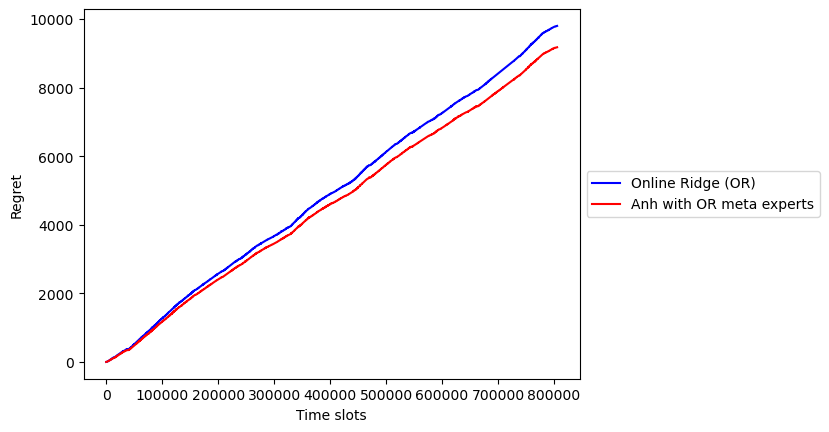

Group number 1, Tg is 763685 

    oridge end regret 8097.955271033139, Anh end regret 7929.016446322092, 

    Anh better Yes 
Oridge regret - Anh regret implementables 168.93882471104735
Relative difference percent 2.1081814792011824


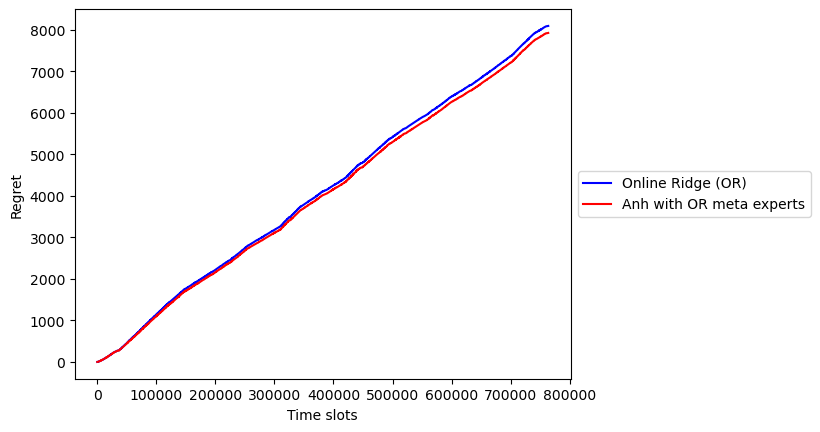

Group number 2, Tg is 1045807 

    oridge end regret 12542.047198795255, Anh end regret 12133.347157407617, 

    Anh better Yes 
Oridge regret - Anh regret implementables 408.7000413876376
Relative difference percent 3.3126120335734295


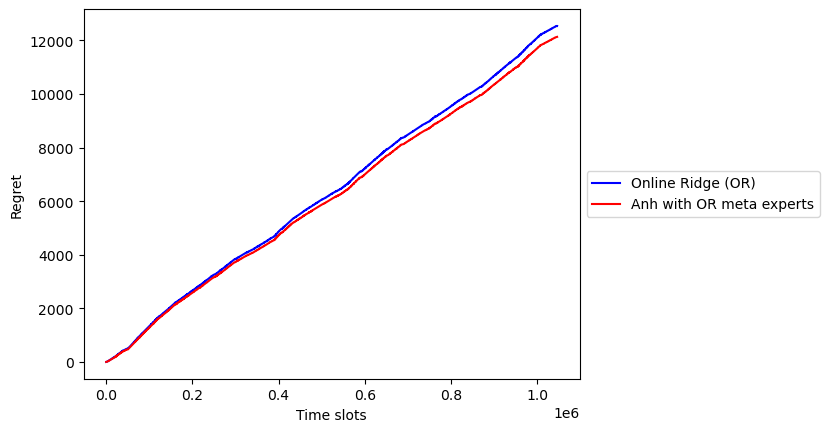

Group number 3, Tg is 136227 

    oridge end regret 962.2536543478632, Anh end regret 938.2806988549869, 

    Anh better Yes 
Oridge regret - Anh regret implementables 23.97295549287628
Relative difference percent 2.522759502081736


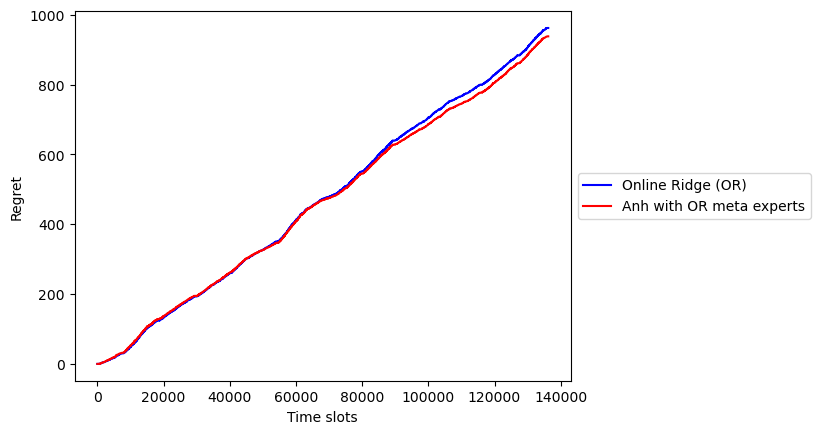

Group number 4, Tg is 14455 

    oridge end regret 78.67766416223901, Anh end regret 69.52434300686116, 

    Anh better Yes 
Oridge regret - Anh regret implementables 9.153321155377853
Relative difference percent 12.352492830861339


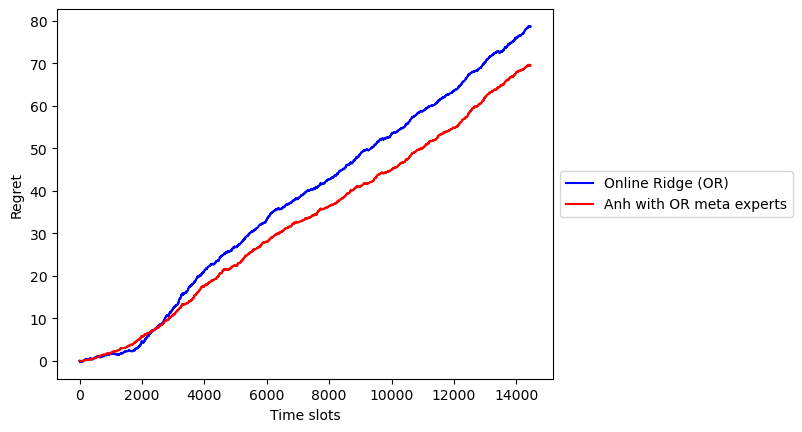

Group number 5, Tg is 726 

    oridge end regret 1.920513754216838, Anh end regret 1.3554640879012005, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.5650496663156375
Relative difference percent 34.496549949209204


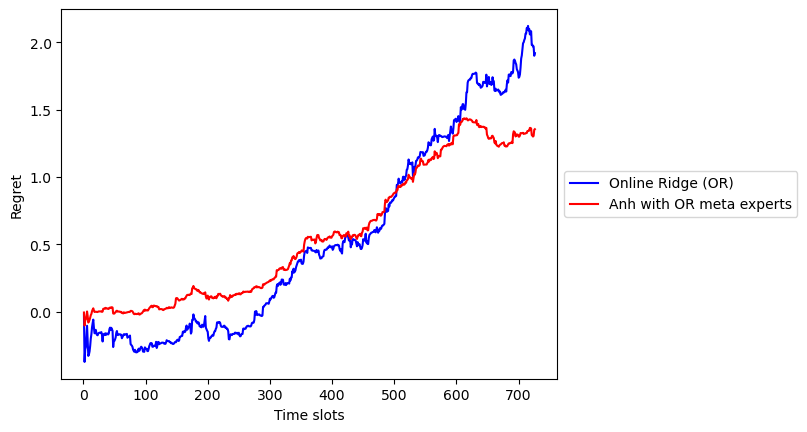

Group number 6, Tg is 2316 

    oridge end regret 12.140052428237958, Anh end regret 8.32720526175816, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.8128471664797985
Relative difference percent 37.25801691883151


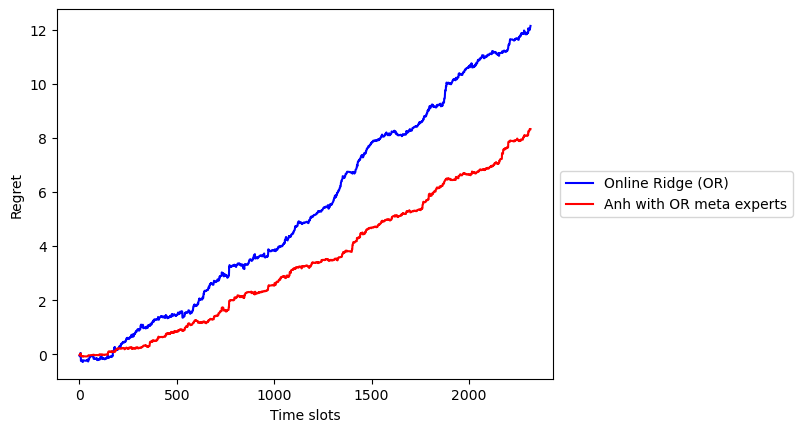

Group number 7, Tg is 100852 

    oridge end regret 1754.7230225586259, Anh end regret 1562.2554533004127, 

    Anh better Yes 
Oridge regret - Anh regret implementables 192.4675692582132
Relative difference percent 11.604993560192911


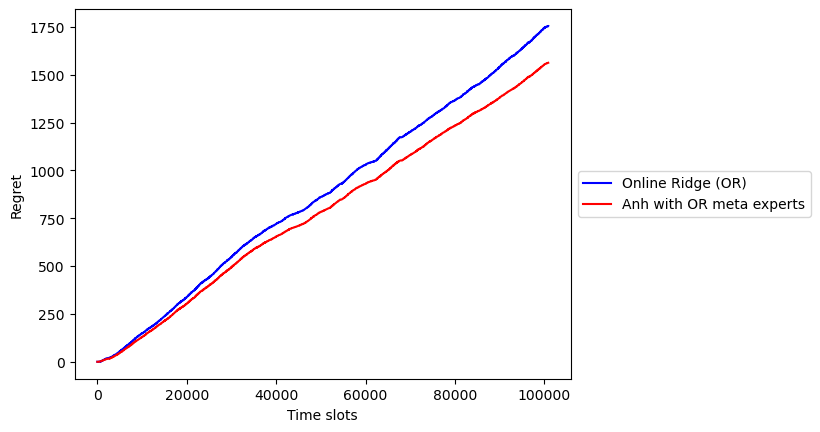

Group number 8, Tg is 2755 

    oridge end regret 10.951599746389633, Anh end regret 9.353876856089855, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.597722890299778
Relative difference percent 15.736866674724407


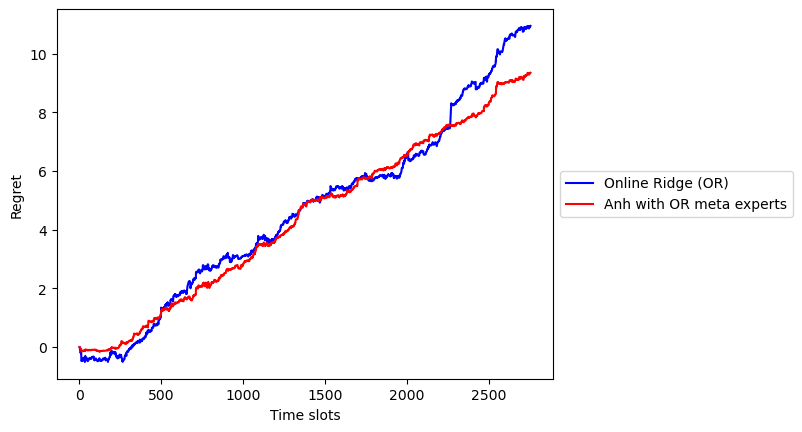

Group number 9, Tg is 97582 

    oridge end regret 724.6524820120962, Anh end regret 584.0773658147605, 

    Anh better Yes 
Oridge regret - Anh regret implementables 140.57511619733577
Relative difference percent 21.482679015957416


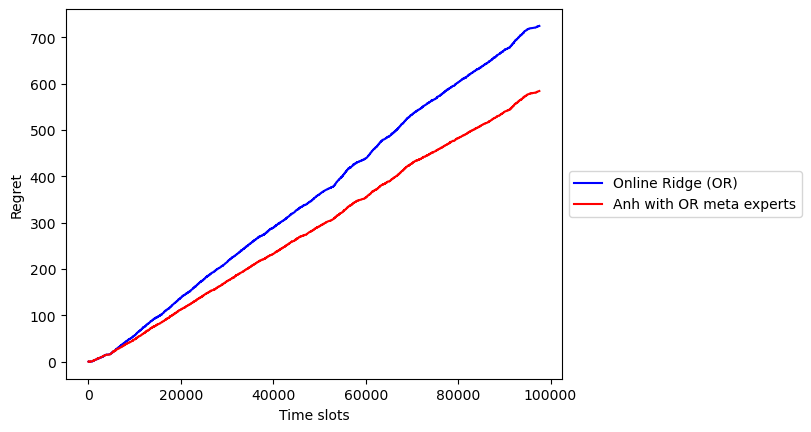

Group number 10, Tg is 168468 

    oridge end regret 1623.625153731672, Anh end regret 1612.5969563175186, 

    Anh better Yes 
Oridge regret - Anh regret implementables 11.02819741415351
Relative difference percent 0.6815476218340206


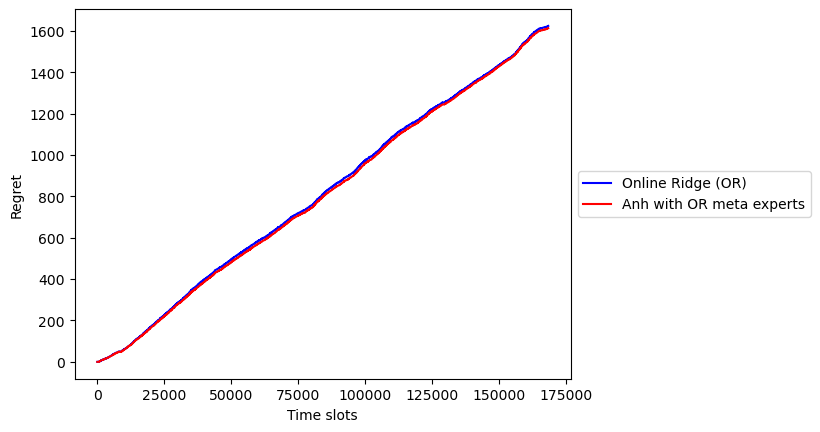

Group number 11, Tg is 1569188 

    oridge end regret 17702.73970472011, Anh end regret 16910.86688409048, 

    Anh better Yes 
Oridge regret - Anh regret implementables 791.8728206296291
Relative difference percent 4.575500207398873


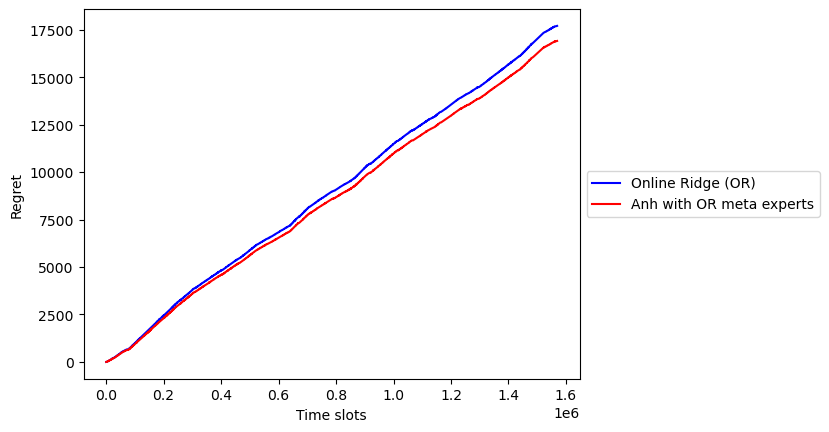

Anh better for 12 out of 12 groups


In [39]:
plot_ORidgevsAnh_together(or_implementable_undropped.cumreg_groupwise_oridge, Anh_undropped)

# Done with UD state by state undropped

# Start D state by state dropped

In [ ]:
# Best squared loss dropped SEX, RAC1P.  
bls_dropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_dropped.update(A_t[t], X_dat_oh_scaled_dropped.iloc[[t]], y_dat_oh_scaled_dropped.iloc[t])

In [ ]:
bls_dropped.make_all_numpyarr()
import joblib
joblib.dump(bls_dropped, './onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl')

In [ ]:
# for ele in X_dat_oh_scaled_dropped.columns: #maybe make it into units tests into the future
#     if '_' not in ele:
#         print(ele)

In [ ]:
X_dat_oh_scaled_dropped.shape, y_dat_oh_scaled_dropped.shape
N = A_t.shape[1]
T = A_t.shape[0]
print(N)
print(T, T == y_dat_oh_scaled_dropped.shape[0])

In [ ]:
# Anh with dropped columns
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_dropped = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_dropped.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_dropped.update_metaexps_loss(A_t[t], X_dat_oh_scaled_dropped.iloc[[t]], y_dat_oh_scaled_dropped.iloc[t]) # update internal states of the meta-experts

In [ ]:
bls_dropped.get_cumbestsqloss()
Anh_dropped.build_cumloss_curve(bls_dropped.best_sqloss, A_t)
Anh_dropped.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved
joblib.dump(Anh_dropped, './onehot_encoded/models/Anh/Anh_dropped_15col_compact.pkl')

In [ ]:
# Build the Implementable Oridge (always active), with dropped columns  V/S  Ada normal hedge with dropped columns
or_implementable_undropped = OnlineRidgeImplementable_alwaysactive(X_dat_oh_scaled, y_dat_oh_scaled) # undropped columns

In [ ]:
with open('./onehot_encoded/models/oridge_implementable/oridge_undropped15colsoh.pkl', 'wb') as f:
    pickle.dump(or_implementable_undropped, f)

In [ ]:
# TODO Rerun with SEX, RAC1P bug which werent dropped
or_implementable_dropped = OnlineRidgeImplementable_alwaysactive(X_dat_oh_scaled_dropped, y_dat_oh_scaled_dropped) # dropped sensitive groups

In [ ]:
with open('./onehot_encoded/models/oridge_implementable/oridge_dropped15colsoh.pkl', 'wb') as f:
    pickle.dump(or_implementable_dropped, f)

In [40]:
# Anh vs oridge(implementable) on dropped sensitive columns
import joblib
A_t = np.load('./onehot_encoded/nparrays/A_t12groups.npy')
Anh_dropped = joblib.load('./onehot_encoded/models/Anh/Anh_dropped_15col_compact.pkl')
or_implementable_dropped = joblib.load('./onehot_encoded/models/oridge_implementable/oridge_dropped15colsoh.pkl')
bls_dropped = joblib.load('./onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl')

In [41]:
bls_dropped.cumbestsqloss()
or_implementable_dropped.fill_subsequence_regrets(A_t, bls_dropped.best_sqloss)

Group number 0, Tg is 805503 

    oridge end regret 10770.921875205655, Anh end regret 9329.174098254873, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1441.7477769507823
Relative difference percent 14.345680526644413


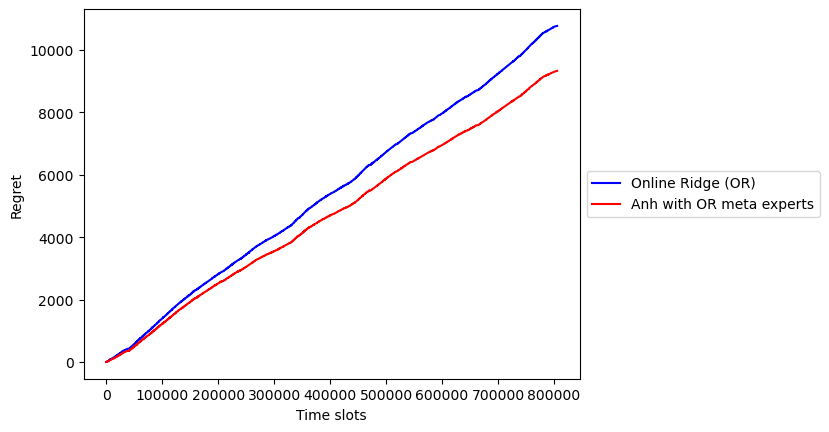

Group number 1, Tg is 763685 

    oridge end regret 8985.724128644457, Anh end regret 8117.497661586129, 

    Anh better Yes 
Oridge regret - Anh regret implementables 868.2264670583281
Relative difference percent 10.152782647702807


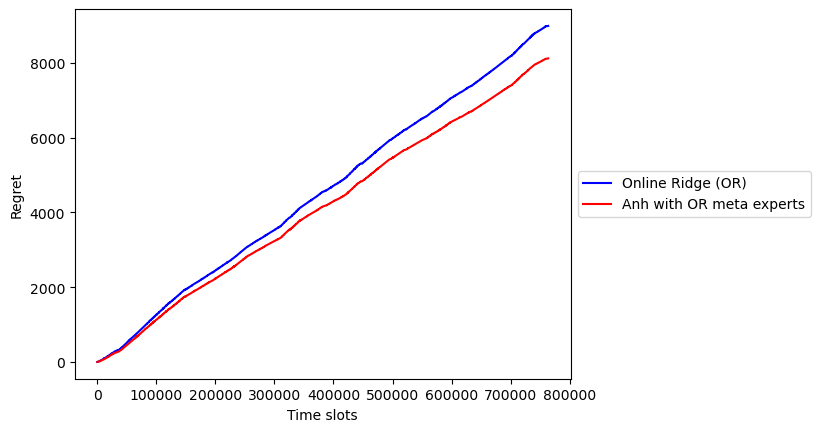

Group number 2, Tg is 1045807 

    oridge end regret 13334.932066637826, Anh end regret 11819.207499803524, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1515.724566834302
Relative difference percent 12.051492064204503


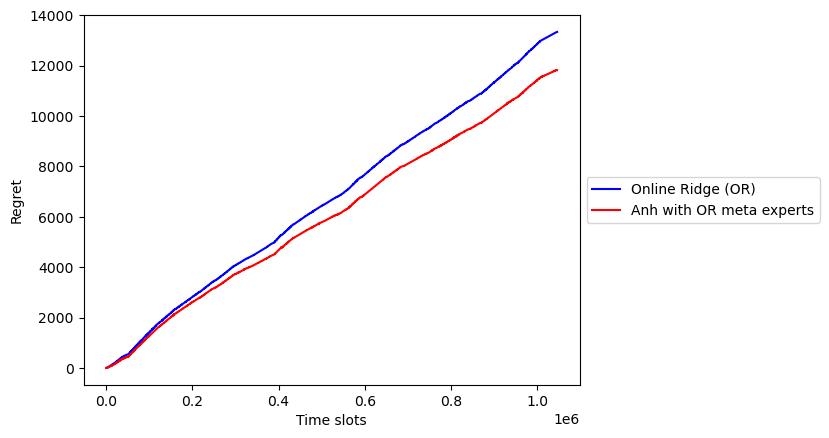

Group number 3, Tg is 136227 

    oridge end regret 1070.6763858050608, Anh end regret 938.2136115975136, 

    Anh better Yes 
Oridge regret - Anh regret implementables 132.46277420754723
Relative difference percent 13.18765829675264


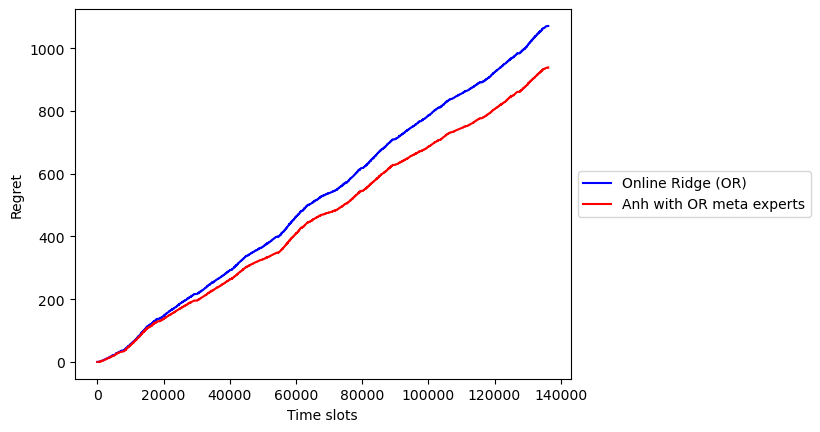

Group number 4, Tg is 14455 

    oridge end regret 91.08333657619607, Anh end regret 71.14291397705256, 

    Anh better Yes 
Oridge regret - Anh regret implementables 19.940422599143517
Relative difference percent 24.58347219533171


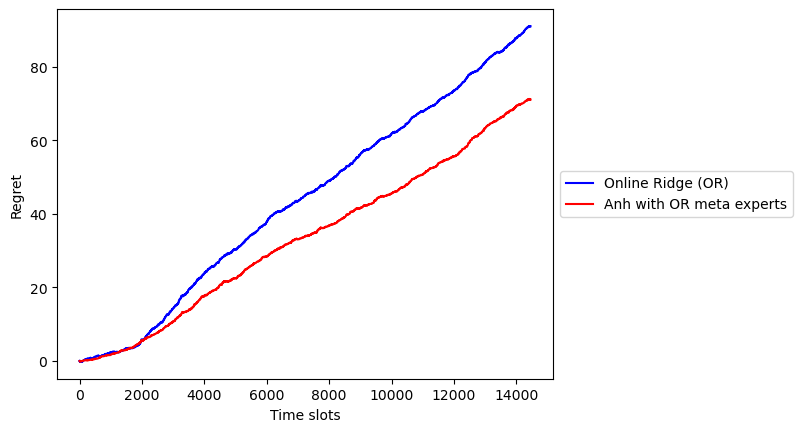

Group number 5, Tg is 726 

    oridge end regret 2.506860615783335, Anh end regret 1.236417284328052, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.270443331455283
Relative difference percent 67.87865423603623


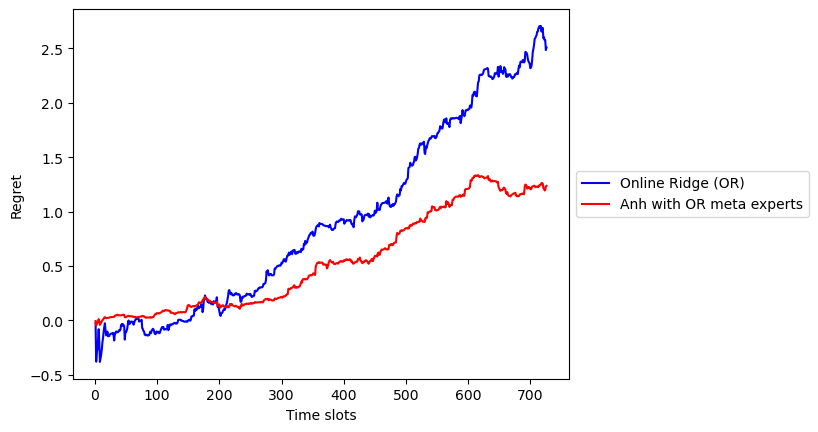

Group number 6, Tg is 2316 

    oridge end regret 13.673292294954265, Anh end regret 8.360966262935214, 

    Anh better Yes 
Oridge regret - Anh regret implementables 5.312326032019051
Relative difference percent 48.21878637815063


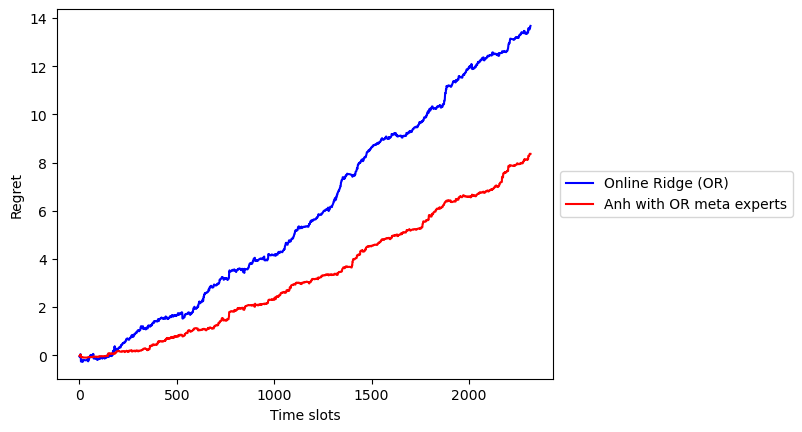

Group number 7, Tg is 100852 

    oridge end regret 1856.5460991641944, Anh end regret 1592.730306001646, 

    Anh better Yes 
Oridge regret - Anh regret implementables 263.8157931625483
Relative difference percent 15.296877499723834


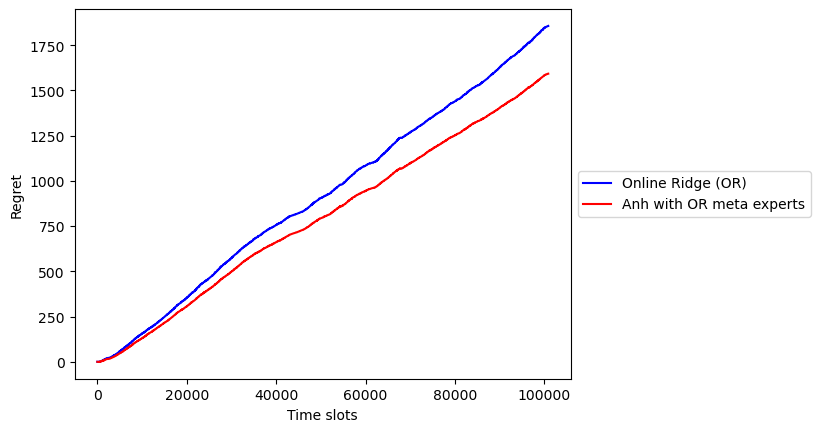

Group number 8, Tg is 2755 

    oridge end regret 13.244923229140312, Anh end regret 9.582714933839327, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.662208295300985
Relative difference percent 32.08573983129025


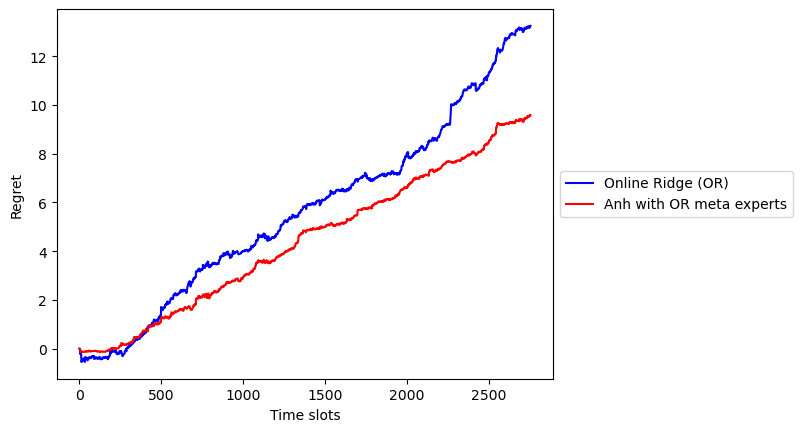

Group number 9, Tg is 97582 

    oridge end regret 860.3519277608511, Anh end regret 606.158381816108, 

    Anh better Yes 
Oridge regret - Anh regret implementables 254.19354594474316
Relative difference percent 34.666451955331944


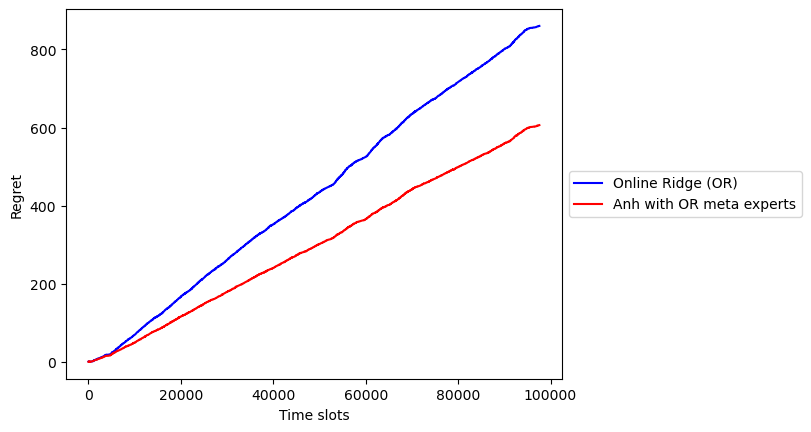

Group number 10, Tg is 168468 

    oridge end regret 1775.3948544313912, Anh end regret 1661.8026908302322, 

    Anh better Yes 
Oridge regret - Anh regret implementables 113.59216360115897
Relative difference percent 6.609580165548086


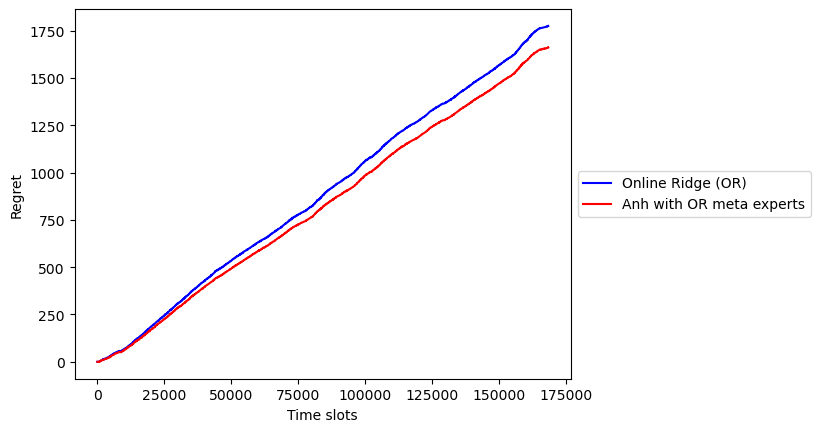

Group number 11, Tg is 1569188 

    oridge end regret 18981.551018925325, Anh end regret 16671.576774916066, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2309.9742440092596
Relative difference percent 12.958045405532568


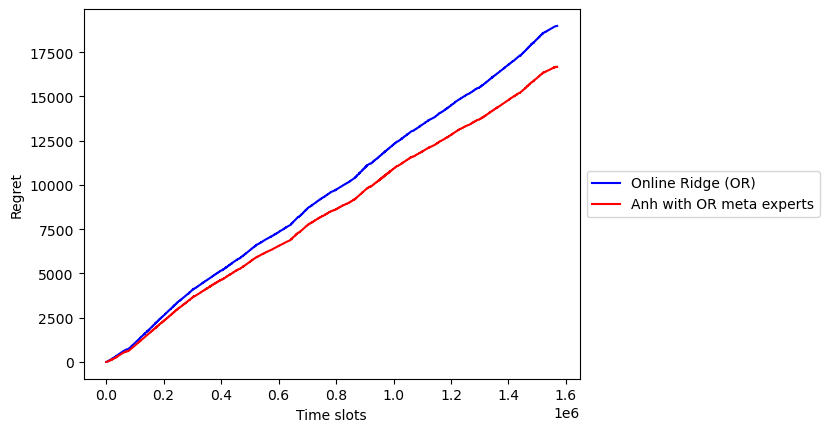

Anh better for 12 out of 12 groups


In [42]:
plot_ORidgevsAnh_together(or_implementable_dropped.cumreg_groupwise_oridge, Anh_dropped)

# Done D State by state dropped

# Start UD iid/random shuffle undropped

In [8]:
data_fil

,OCCP,WKHP,AGEP,SCHL,ST,JWTRNS,DRAT,COW,SEX,RELSHIPP,POBP,ENG,MAR,RAC1P,PINCP
0,4760,30.0,19.0,18,1,0,0,2,2,38,53,0,5,1,8000.0
1,4640,40.0,20.0,19,1,1,0,1,1,38,13,0,5,2,6300.0
2,5240,18.0,19.0,18,1,0,0,2,2,38,22,0,5,1,6200.0
3,4220,6.0,34.0,19,1,12,0,2,2,38,18,0,3,1,10800.0
4,2722,10.0,19.0,18,1,0,0,1,1,38,36,0,5,1,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,1430,40.0,40.0,21,72,1,0,1,2,20,72,2,5,9,80000.0
1630163,2205,40.0,47.0,22,72,1,0,2,1,20,72,3,1,9,60000.0
1630164,5740,40.0,46.0,21,72,1,0,4,2,21,72,0,1,9,18600.0
1630165,2634,30.0,22.0,21,72,11,0,6,1,25,72,2,5,9,12200.0


# Start desc undropped

In [6]:
#  y_values, undropped (sensitive) columns, hypothesis is larger performance gap than earlier
print(cat_cols_sig)
df_oh = one_hot(data_fil, cat_cols_sig) # cat_cols_sig determined in 2buildmodels_withtargetencoding
print(df_oh.shape)


['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P']
(1569188, 910)


In [7]:
df_oh_sorted = df_oh.sort_values(by=['PINCP'], ascending=False) # sorted in descending order

In [8]:
df_oh_sorted['PINCP']

964206     200000.0
96685      200000.0
487235     200000.0
60178      200000.0
1158858    200000.0
             ...   
583318        110.0
1465699       110.0
125202        110.0
1237948       110.0
697930        110.0
Name: PINCP, Length: 1569188, dtype: float64

In [10]:
df_oh_sorted.drop(cat_cols_sig, axis = 1)

,OCCP,WKHP,AGEP,SCHL,ST,JWTRNS,DRAT,COW,SEX,RELSHIPP,...,MAR_5,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
964206,850,40.0,55.0,21,36,1,0,1,1,20,...,0,0,1,0,0,0,0,0,0,0
96685,4920,75.0,43.0,22,6,1,0,7,2,21,...,0,1,0,0,0,0,0,0,0,0
487235,2640,40.0,50.0,22,17,11,0,1,2,21,...,0,1,0,0,0,0,0,0,0,0
60178,3603,40.0,26.0,18,4,1,0,1,2,20,...,1,1,0,0,0,0,0,0,0,0
1158858,860,40.0,32.0,21,39,12,0,1,1,20,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583318,4621,25.0,18.0,16,19,0,0,3,1,38,...,1,0,0,0,0,0,0,0,1,0
1465699,4110,8.0,18.0,16,48,0,0,1,2,25,...,1,1,0,0,0,0,0,0,0,0
125202,2722,4.0,17.0,15,6,0,0,1,1,25,...,1,0,0,0,0,0,0,0,0,1
1237948,4020,15.0,17.0,13,42,0,0,1,1,25,...,1,1,0,0,0,0,0,0,0,0


In [9]:
gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']
A_tdf = df_oh_sorted[gnames]
A_tdf['alwayson'] = 1
A_t = A_tdf.to_numpy()

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_56023/1923233606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1


In [ ]:
# np.save('./onehot_encoded/nparrays/A_t12groups_descPINCP', A_t)

In [ ]:
# df_oh_sorted = df_oh_sorted.drop(cat_cols_sig, axis=1)


In [ ]:
df_oh_sorted_scaled = numeric_scaler(df_oh_sorted, df_oh_sorted.columns) # minmax scale all columns

In [ ]:
df_oh_sorted_scaled.head()

In [ ]:
N = A_t.shape[1] #  12 groups 11 + 1 always active
d = df_oh_sorted_scaled.shape[1] 
T = df_oh_sorted_scaled.shape[0]
print(N, d, T)

X_dat_oh_sorted_scaled = df_oh_sorted_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_oh_sorted_scaled = pd.DataFrame(df_oh_sorted_scaled['PINCP']) # picking up only the income column for the target

print(X_dat_oh_sorted_scaled.shape, y_dat_oh_sorted_scaled.shape)


In [ ]:
# Best square loss in hindsight for sorted PINCP descending, (undropped sensitive columns)
bls_undropped_sorteddesc = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_undropped_sorteddesc.update(A_t[t], X_dat_oh_sorted_scaled.iloc[[t]], y_dat_oh_sorted_scaled.iloc[t])

In [ ]:
import joblib
bls_undropped_sorteddesc.make_all_numpyarr()
joblib.dump(bls_undropped_sorteddesc, './onehot_encoded/models/bestsqloss/bls_oh_undropped_sorteddesc.pkl')

In [ ]:
# Anh for sorted PINCP descending, (undropped sensitive columns)
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_undropped_sorteddesc = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_undropped_sorteddesc.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_undropped_sorteddesc.update_metaexps_loss(A_t[t], X_dat_oh_sorted_scaled.iloc[[t]], y_dat_oh_sorted_scaled.iloc[t]) # update internal states of the meta-experts

In [ ]:
bls_undropped_sorteddesc.cumbestsqloss()
Anh_undropped_sorteddesc.build_cumloss_curve(bls_undropped_sorteddesc.best_sqloss, A_t)
Anh_undropped_sorteddesc.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved


joblib.dump(Anh_undropped_sorteddesc, './onehot_encoded/models/Anh/Anh_undropped_sorteddesc.pkl')

In [ ]:
or_implementable_undropped_sorteddesc = OnlineRidgeImplementable_alwaysactive(X_dat_oh_sorted_scaled, y_dat_oh_sorted_scaled) # undropped columns
joblib.dump(or_implementable_undropped_sorteddesc, './onehot_encoded/models/oridge_implementable/or_implementable_undropped_sorteddesc.pkl')

In [ ]:
or_implementable_undropped_sorteddesc.fill_subsequence_regrets(A_t, bls_undropped_sorteddesc.best_sqloss)

In [44]:
# reloading saved arrays and models
A_t = np.load('./onehot_encoded/nparrays/A_t12groups_descPINCP.npy')
Anh_undropped_sorteddesc = joblib.load('./onehot_encoded/models/Anh/Anh_undropped_sorteddesc.pkl')
or_implementable_undropped_sorteddesc = joblib.load('./onehot_encoded/models/oridge_implementable/or_implementable_undropped_sorteddesc.pkl')
bls_undropped_sorteddesc = joblib.load('./onehot_encoded/models/bestsqloss/bls_oh_undropped_sorteddesc.pkl')

In [46]:
bls_undropped_sorteddesc.cumbestsqloss()
or_implementable_undropped_sorteddesc.fill_subsequence_regrets(A_t, bls_undropped_sorteddesc.best_sqloss)

Group number 0, Tg is 805503 

    oridge end regret -5.293152663639122, Anh end regret -3.5045280780890486, 

    Anh better No 
Oridge regret - Anh regret implementables -1.7886245855500738
Relative difference percent 40.66127512598793


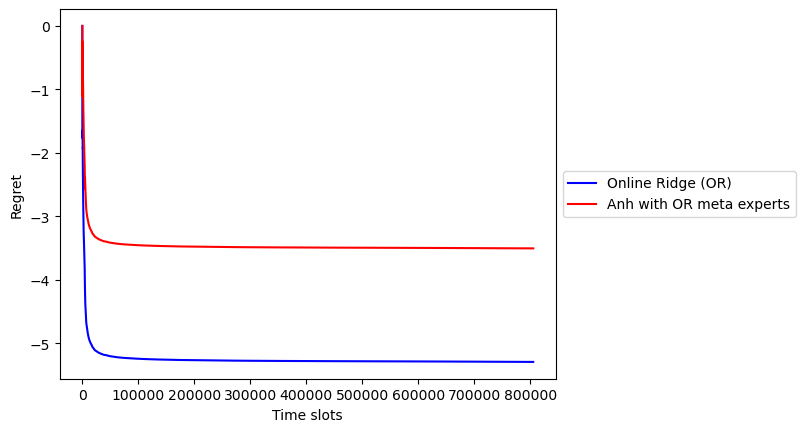

Group number 1, Tg is 763685 

    oridge end regret -5.011443795342736, Anh end regret -4.2898376610318465, 

    Anh better No 
Oridge regret - Anh regret implementables -0.7216061343108899
Relative difference percent 15.51627348759221


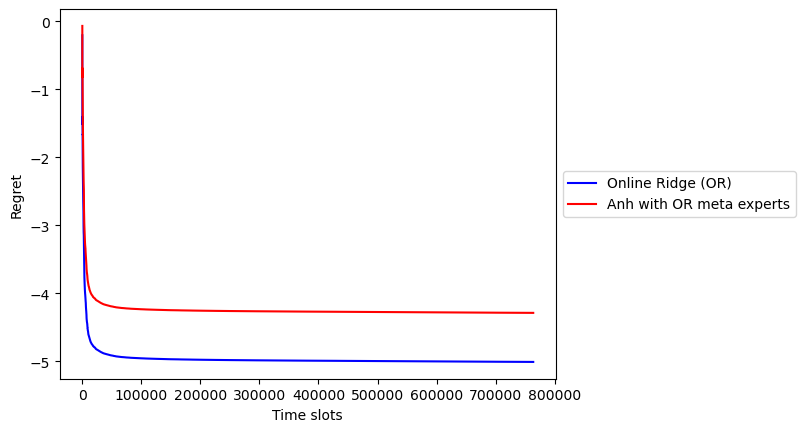

Group number 2, Tg is 1045807 

    oridge end regret -4.0008710693540275, Anh end regret -3.346520208530306, 

    Anh better No 
Oridge regret - Anh regret implementables -0.6543508608237216
Relative difference percent 17.81178750594975


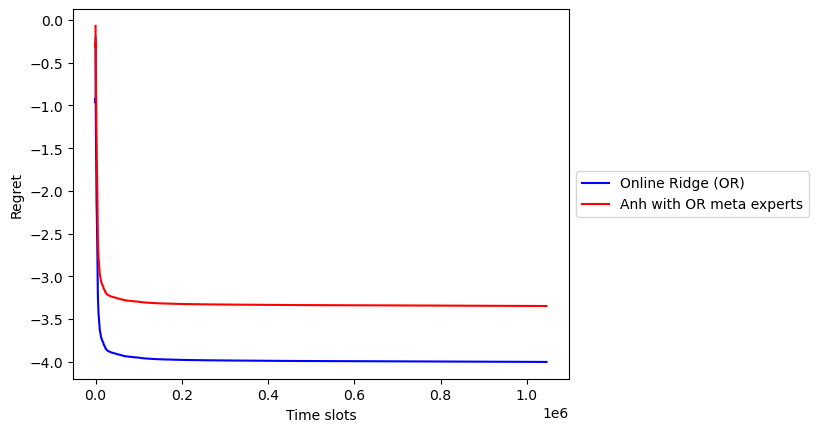

Group number 3, Tg is 136227 

    oridge end regret -5.8625624934076, Anh end regret -5.665568852883687, 

    Anh better No 
Oridge regret - Anh regret implementables -0.196993640523913
Relative difference percent 3.4176161705042993


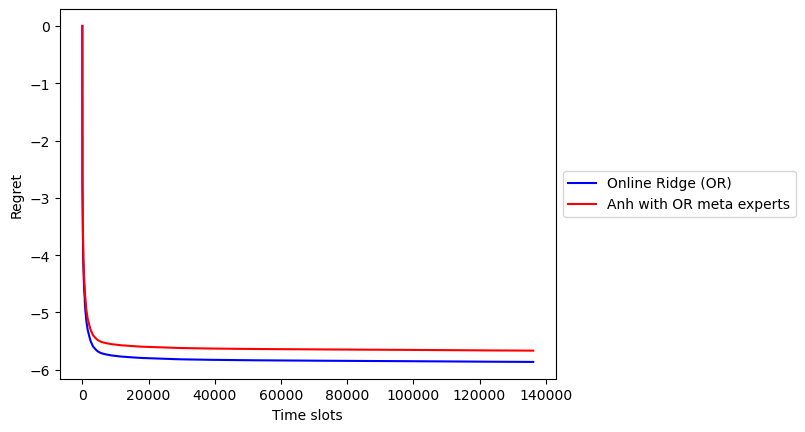

Group number 4, Tg is 14455 

    oridge end regret -5.678779160242852, Anh end regret -5.47271085164689, 

    Anh better No 
Oridge regret - Anh regret implementables -0.20606830859596226
Relative difference percent 3.6957986489025556


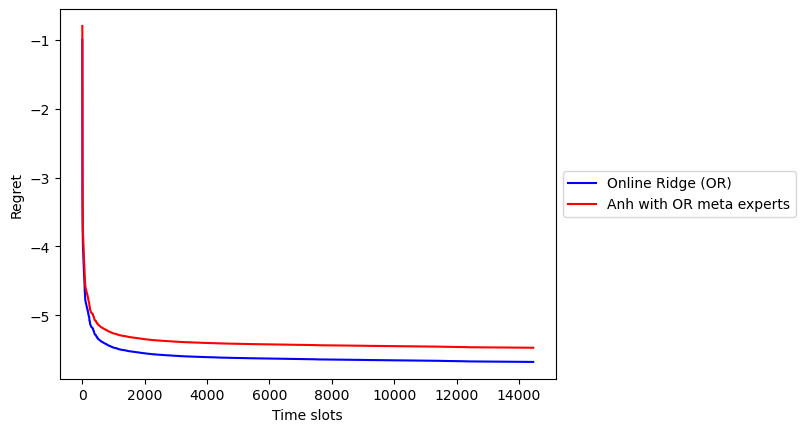

Group number 5, Tg is 726 

    oridge end regret -2.9943130178314967, Anh end regret -2.8188286282322133, 

    Anh better No 
Oridge regret - Anh regret implementables -0.17548438959928347
Relative difference percent 6.03750606070679


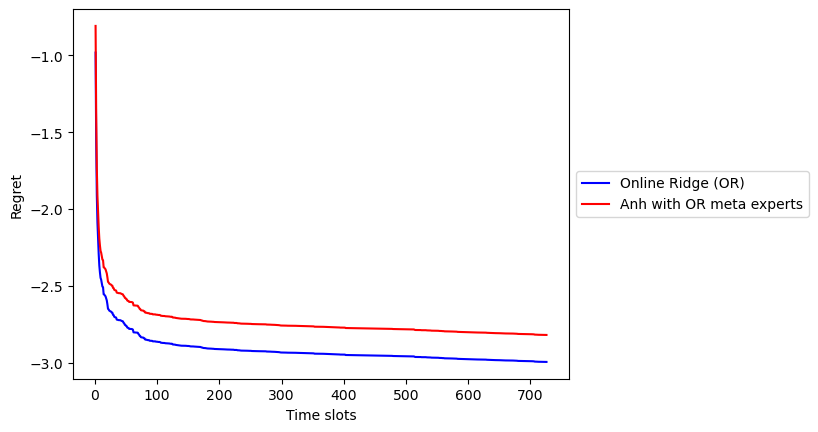

Group number 6, Tg is 2316 

    oridge end regret -4.516599406090558, Anh end regret -4.305145498165676, 

    Anh better No 
Oridge regret - Anh regret implementables -0.2114539079248816
Relative difference percent 4.793924789705974


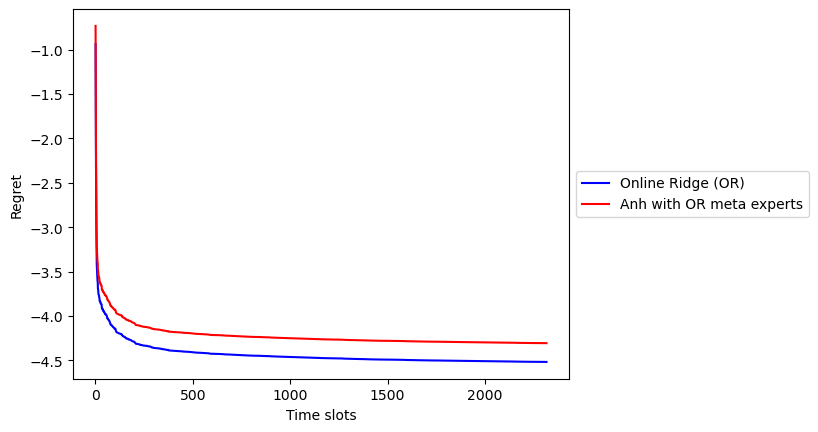

Group number 7, Tg is 100852 

    oridge end regret -6.223802644012035, Anh end regret -5.883878998858604, 

    Anh better No 
Oridge regret - Anh regret implementables -0.3399236451534309
Relative difference percent 5.615007978898884


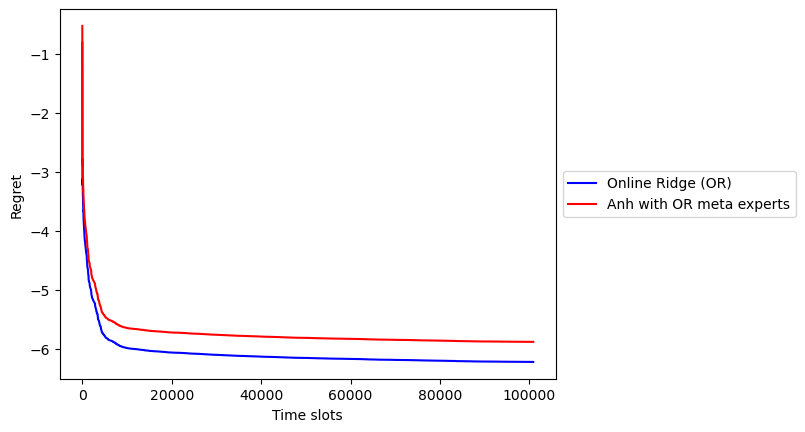

Group number 8, Tg is 2755 

    oridge end regret -4.86380251313809, Anh end regret -4.672339400701666, 

    Anh better No 
Oridge regret - Anh regret implementables -0.19146311243642433
Relative difference percent 4.015525653169126


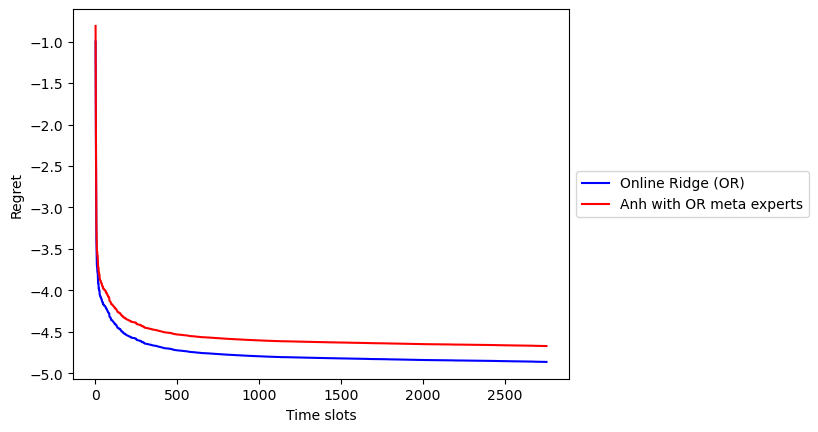

Group number 9, Tg is 97582 

    oridge end regret -6.705546091963434, Anh end regret -6.464658400761904, 

    Anh better No 
Oridge regret - Anh regret implementables -0.24088769120153053
Relative difference percent 3.658070629572786


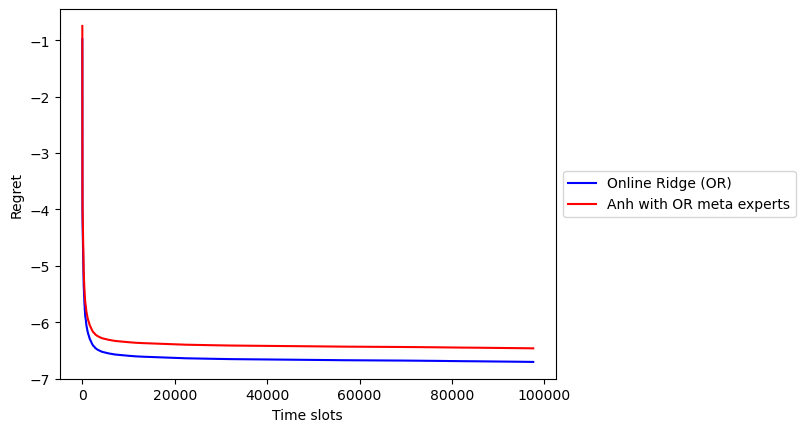

Group number 10, Tg is 168468 

    oridge end regret -6.7797371743269, Anh end regret -6.486132010723129, 

    Anh better No 
Oridge regret - Anh regret implementables -0.29360516360377176
Relative difference percent 4.426474579361149


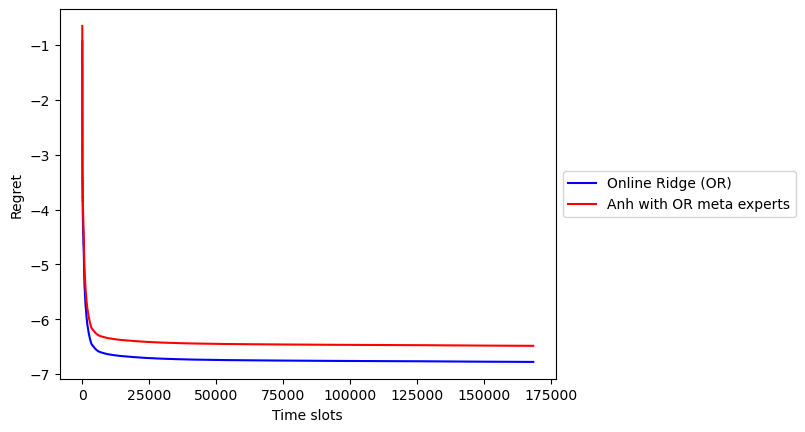

Group number 11, Tg is 1569188 

    oridge end regret -3.501716525342916, Anh end regret -0.9914858054854125, 

    Anh better No 
Oridge regret - Anh regret implementables -2.5102307198575033
Relative difference percent 111.73459528561843


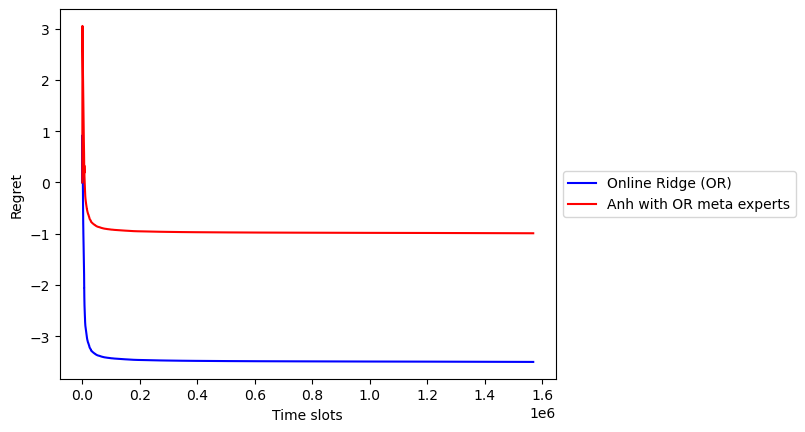

Anh better for 0 out of 12 groups


In [47]:
# DESCENDING UNDROPPED
plot_ORidgevsAnh_together(or_implementable_undropped_sorteddesc.cumreg_groupwise_oridge, Anh_undropped_sorteddesc)

# Done Desc undropped

# Start Asc undropped

In [ ]:
# # Ascending y values
# A_t array for ascending PINCP
gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']
A_tdf = df_oh_sorted[::-1][gnames] # ascending A_t
A_tdf['alwayson'] = 1
A_t = A_tdf.to_numpy()

In [ ]:
np.save('./onehot_encoded/nparrays/A_t_ascPINCP', A_t)

In [ ]:
np.all(A_t == np.load('./onehot_encoded/nparrays/A_t_ascPINCP.npy'))

In [ ]:
df_oh_ascending = df_oh_sorted_scaled[::-1]

In [ ]:
# for col in df_oh_sorted_scaled.columns:
#     if '_' not in col:
#         print(col)

In [ ]:
X_dat_ascending = df_oh_ascending.drop('PINCP', axis=1) #dropping the income column
y_dat_ascending = pd.DataFrame(df_oh_ascending['PINCP']) # picking up only the income column for the target


In [ ]:
# X_dat_ascending.head(), y_dat_ascending.head()

In [ ]:
N = A_t.shape[1] #  12 groups 11 + 1 always active
d = df_oh_sorted_scaled.shape[1] 
T = df_oh_sorted_scaled.shape[0]
print(N, d, T)

In [ ]:
# bls undropped sorted ascending
bls_undropped_ascending = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_undropped_ascending.update(A_t[t], X_dat_ascending.iloc[[t]], y_dat_ascending.iloc[t])

In [ ]:
import joblib
bls_undropped_ascending.make_all_numpyarr()
joblib.dump(bls_undropped_ascending, './onehot_encoded/models/bestsqloss/bls_undropped_ascending.pkl')

In [ ]:
# Anh undropped sorted ascending PINCP
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_undropped_sortedasc = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_undropped_sortedasc.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_undropped_sortedasc.update_metaexps_loss(A_t[t], X_dat_ascending.iloc[[t]], y_dat_ascending.iloc[t]) # update internal states of the meta-experts

In [ ]:
bls_undropped_ascending.cumbestsqloss()
Anh_undropped_sortedasc.build_cumloss_curve(bls_undropped_ascending.best_sqloss, A_t)
Anh_undropped_sortedasc.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved

joblib.dump(Anh_undropped_sortedasc, './onehot_encoded/models/Anh/Anh_undropped_sortedasc.pkl')

In [ ]:
# oridge implementable
or_implementable_undropped_sortedasc = OnlineRidgeImplementable_alwaysactive(X_dat_ascending, y_dat_ascending) # undropped columns
joblib.dump(or_implementable_undropped_sortedasc, './onehot_encoded/models/oridge_implementable/or_implementable_undropped_sortedasc.pkl')

In [ ]:
or_implementable_undropped_sortedasc.fill_subsequence_regrets(A_t, bls_undropped_ascending.best_sqloss)

In [49]:
A_t = np.load('./onehot_encoded/nparrays/A_t_ascPINCP.npy')
Anh_undropped_sortedasc = joblib.load('./onehot_encoded/models/Anh/Anh_undropped_sortedasc.pkl')
bls_undropped_ascending = joblib.load('./onehot_encoded/models/bestsqloss/bls_undropped_ascending.pkl')
or_implementable_undropped_sortedasc = joblib.load('./onehot_encoded/models/oridge_implementable/or_implementable_undropped_sortedasc.pkl')

In [52]:
bls_undropped_ascending.cumbestsqloss()
or_implementable_undropped_sortedasc.fill_subsequence_regrets(A_t, bls_undropped_ascending.best_sqloss)

Group number 0, Tg is 805503 

    oridge end regret -0.16745312645729296, Anh end regret 0.1401385505565261, 

    Anh better No 
Oridge regret - Anh regret implementables -0.30759167701381906
Relative difference percent 200.0


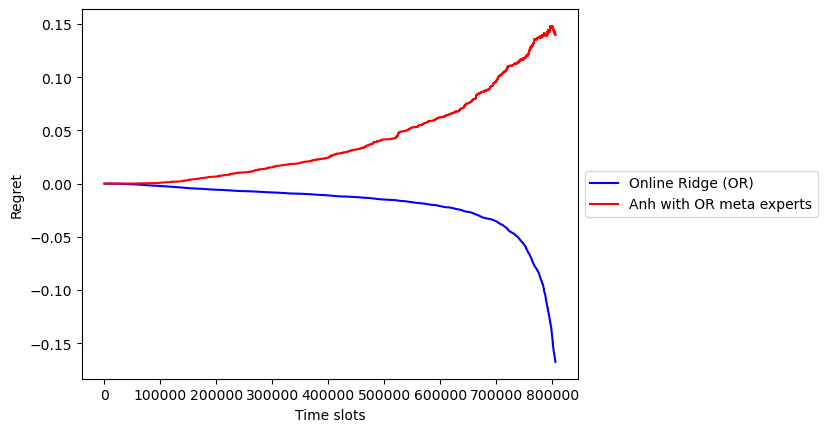

Group number 1, Tg is 763685 

    oridge end regret -0.2696202052436928, Anh end regret -0.030246932082911765, 

    Anh better No 
Oridge regret - Anh regret implementables -0.23937327316078102
Relative difference percent 159.65288847244653


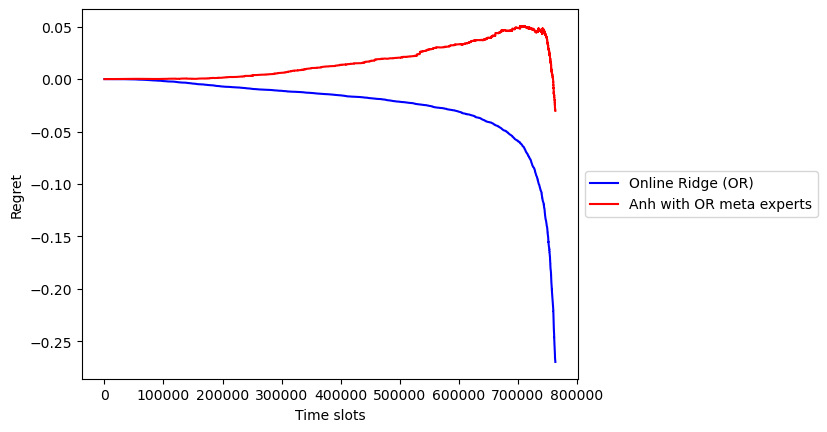

Group number 2, Tg is 1045807 

    oridge end regret -0.13303622315603067, Anh end regret -0.1232673506351999, 

    Anh better No 
Oridge regret - Anh regret implementables -0.009768872520830765
Relative difference percent 7.6228921636402145


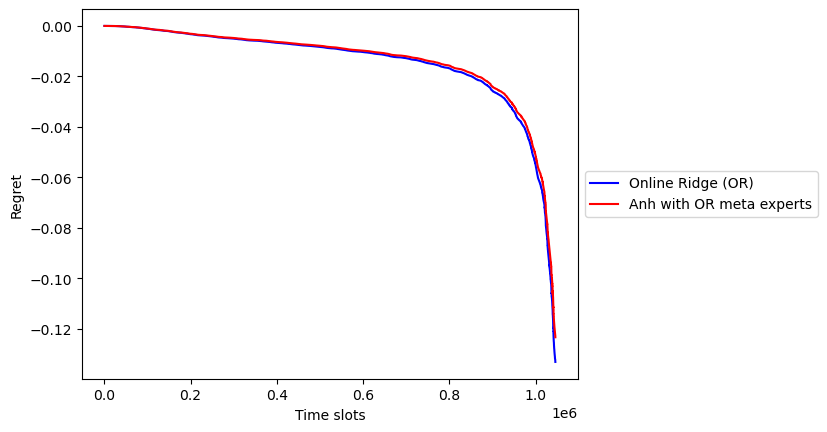

Group number 3, Tg is 136227 

    oridge end regret -0.3176787243559138, Anh end regret -0.2801013785776204, 

    Anh better No 
Oridge regret - Anh regret implementables -0.037577345778293414
Relative difference percent 12.572297269141977


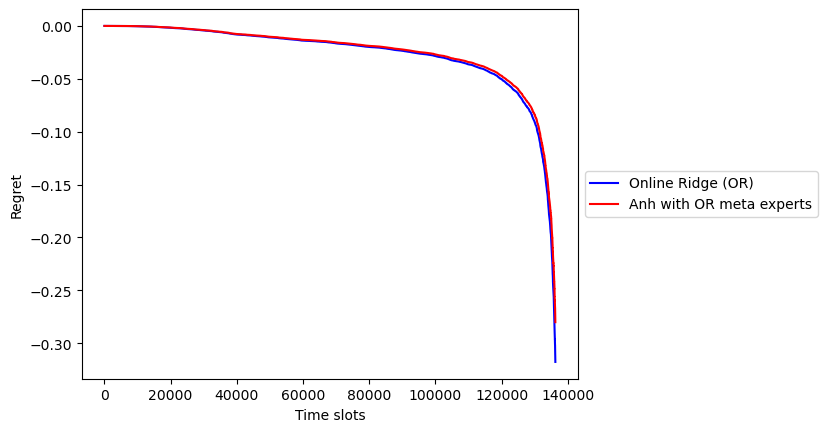

Group number 4, Tg is 14455 

    oridge end regret -0.46693788157200034, Anh end regret -0.38492140586228174, 

    Anh better No 
Oridge regret - Anh regret implementables -0.0820164757097186
Relative difference percent 19.255874043879782


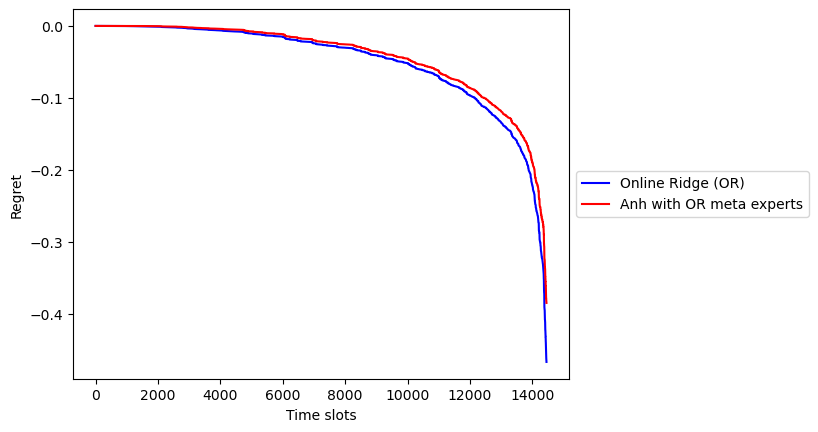

Group number 5, Tg is 726 

    oridge end regret -0.38332227271055436, Anh end regret -0.2814780964416782, 

    Anh better No 
Oridge regret - Anh regret implementables -0.10184417626887615
Relative difference percent 30.639025185485373


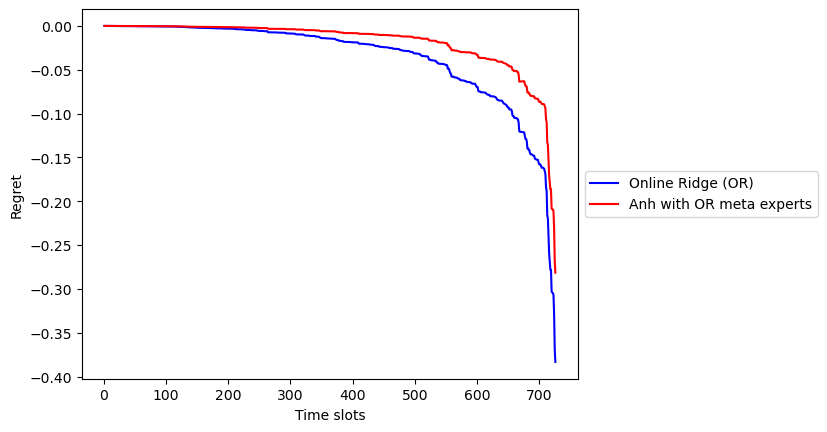

Group number 6, Tg is 2316 

    oridge end regret -0.47138138333085433, Anh end regret -0.3690354330976444, 

    Anh better No 
Oridge regret - Anh regret implementables -0.10234595023320991
Relative difference percent 24.355997698415244


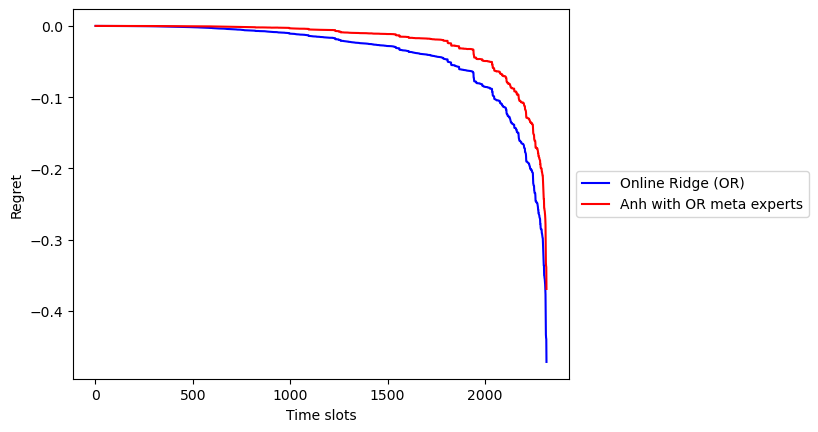

Group number 7, Tg is 100852 

    oridge end regret -0.4472016599694427, Anh end regret -0.4199546780629293, 

    Anh better No 
Oridge regret - Anh regret implementables -0.027246981906513423
Relative difference percent 6.284214440117777


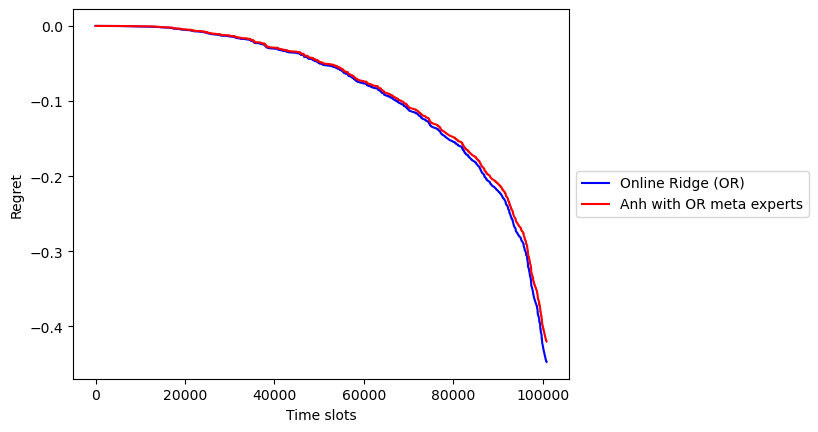

Group number 8, Tg is 2755 

    oridge end regret -0.526560906401234, Anh end regret -0.4237855161331698, 

    Anh better No 
Oridge regret - Anh regret implementables -0.1027753902680642
Relative difference percent 21.629037123953314


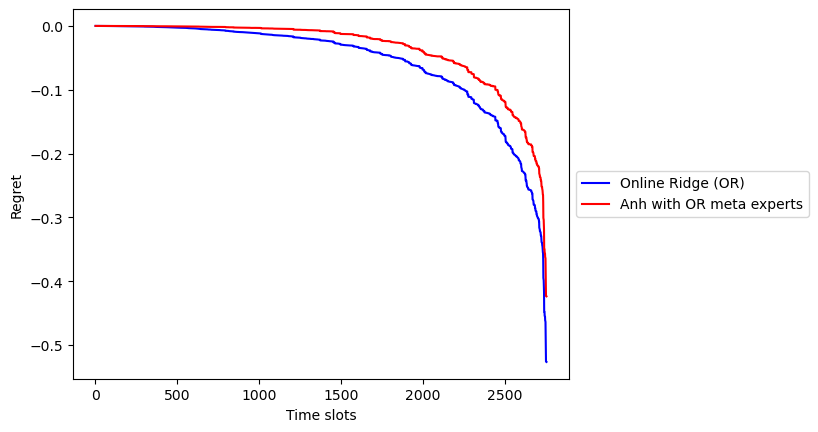

Group number 9, Tg is 97582 

    oridge end regret -0.397537303261382, Anh end regret -0.3442137055539213, 

    Anh better No 
Oridge regret - Anh regret implementables -0.0533235977074607
Relative difference percent 14.377762099070724


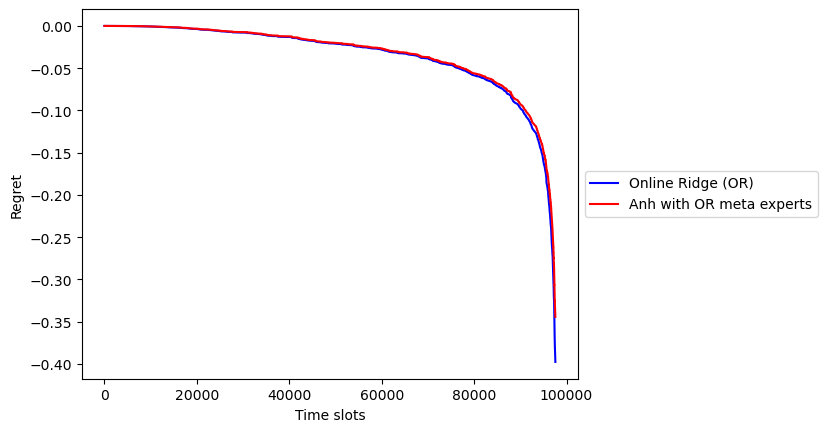

Group number 10, Tg is 168468 

    oridge end regret -0.31097901777511344, Anh end regret -0.2809128579934583, 

    Anh better No 
Oridge regret - Anh regret implementables -0.030066159781655166
Relative difference percent 10.159341938124848


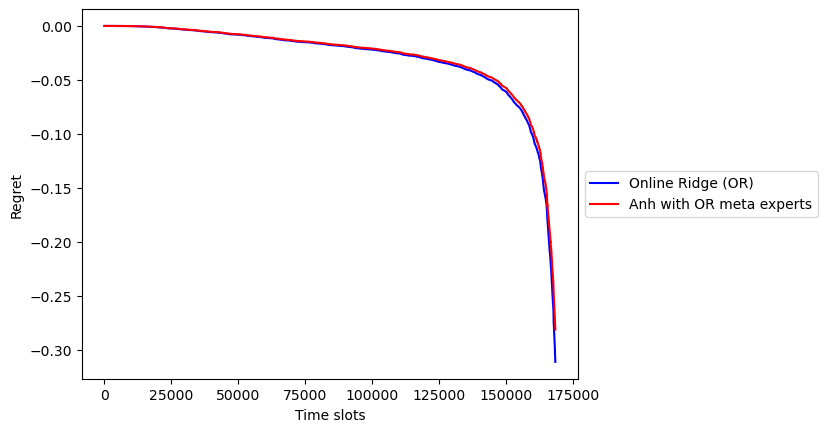

Group number 11, Tg is 1569188 

    oridge end regret -0.1792272615415757, Anh end regret 0.3677376886330033, 

    Anh better No 
Oridge regret - Anh regret implementables -0.546964950174579
Relative difference percent 200.0


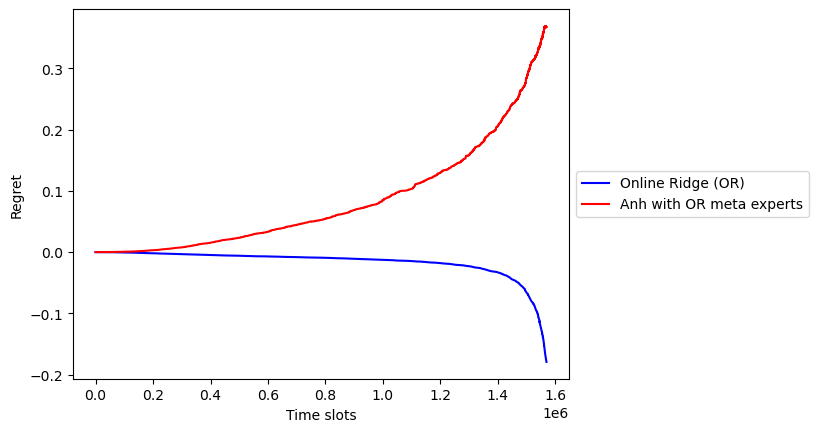

Anh better for 0 out of 12 groups


In [53]:
# ASCENDING UNDROPPED
plot_ORidgevsAnh_together(or_implementable_undropped_sortedasc.cumreg_groupwise_oridge, Anh_undropped_sortedasc)

# Done Asc undropped 

# Start Desc dropped columns

In [13]:
cat_cols_sig

['OCCP',
 'SCHL',
 'ST',
 'JWTRNS',
 'DRAT',
 'COW',
 'SEX',
 'RELSHIPP',
 'POBP',
 'ENG',
 'MAR',
 'RAC1P']

In [14]:
print(cat_cols_sig)
df_oh = one_hot(data_fil, cat_cols_sig) # cat_cols_sig determined in 2buildmodels_withtargetencoding
print(df_oh.shape)

['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P']
(1569188, 910)


In [15]:
gnames = ['SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2', 'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9']

In [16]:
df_oh.drop(cat_cols_sig, axis = 1, inplace = True)

In [17]:
df_oh.sort_values(by = ['PINCP'], ascending = False, inplace = True) # sorted in descending order

In [18]:
A_tdf = df_oh[gnames]
A_tdf['alwayson'] = 1
A_t = A_tdf.to_numpy()

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_96052/3066114811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1


In [19]:
np.all(A_t == np.load('./onehot_encoded/nparrays/A_t12groups_descPINCP.npy'))

True

In [20]:
df_oh.drop(gnames, axis = 1, inplace = True)

In [21]:
df_oh_dropped_desc_scaled =  numeric_scaler(df_oh, df_oh.columns)

In [22]:
N = A_t.shape[1] #  12 groups 11 + 1 always active
d = df_oh_dropped_desc_scaled.shape[1] # d uses all 15 columns
T = df_oh_dropped_desc_scaled.shape[0] # ~1.5 million points

print(N, d, T)

12 887 1569188


In [23]:
X_dat_desc_drop = df_oh_dropped_desc_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_desc_drop = pd.DataFrame(df_oh_dropped_desc_scaled['PINCP'])

In [91]:
# best square loss desc dropped
bls_desc_drop = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_desc_drop.update(A_t[t], X_dat_desc_drop.iloc[[t]], y_dat_desc_drop.iloc[t])

100%|██████████| 1569188/1569188 [36:59<00:00, 706.91it/s]  


In [92]:
import joblib
bls_desc_drop.make_all_numpyarr()
joblib.dump(bls_desc_drop, './onehot_encoded/models/bestsqloss/bls_desc_drop.pkl')

['./onehot_encoded/models/bestsqloss/bls_desc_drop.pkl']

In [93]:
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_desc_drop = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_desc_drop.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_desc_drop.update_metaexps_loss(A_t[t], X_dat_desc_drop.iloc[[t]], y_dat_desc_drop.iloc[t]) # update internal states of the meta-experts

100%|██████████| 1569188/1569188 [38:32<00:00, 678.44it/s]


In [94]:
bls_desc_drop.cumbestsqloss()
Anh_desc_drop.build_cumloss_curve(bls_desc_drop.best_sqloss, A_t)
Anh_desc_drop.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved

joblib.dump(Anh_desc_drop, './onehot_encoded/models/Anh/Anh_desc_drop.pkl')

['./onehot_encoded/models/Anh/Anh_desc_drop.pkl']

In [24]:
or_implementable_desc_drop =  OnlineRidgeImplementable_alwaysactive(X_dat_desc_drop, y_dat_desc_drop) # undropped columns
or_implementable_desc_drop.fill_subsequence_regrets(A_t, bls_desc_drop.best_sqloss)
joblib.dump(or_implementable_desc_drop, './onehot_encoded/models/oridge_implementable/or_implementable_desc_drop.pkl')

100%|██████████| 1569188/1569188 [13:40<00:00, 1913.25it/s]


['./onehot_encoded/models/oridge_implementable/or_implementable_desc_drop.pkl']

In [2]:
import joblib
Anh_desc_drop = joblib.load('./onehot_encoded/models/Anh/Anh_desc_drop.pkl')
bls_desc_drop = joblib.load( './onehot_encoded/models/bestsqloss/bls_desc_drop.pkl')

In [5]:
bls_desc_drop.cumbestsqloss()

Group number 0, Tg is 805503 

    oridge end regret -9.622097493257158, Anh end regret -7.82950096761336, 

    Anh better No 
Oridge regret - Anh regret implementables -1.7925965256437983
Relative difference percent 20.54363707328137


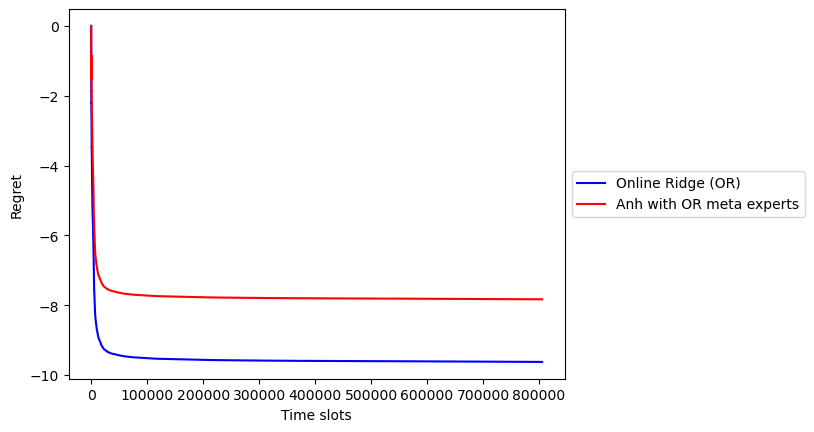

Group number 1, Tg is 763685 

    oridge end regret -9.28252683984686, Anh end regret -8.540080608059316, 

    Anh better No 
Oridge regret - Anh regret implementables -0.7424462317875431
Relative difference percent 8.331510795574042


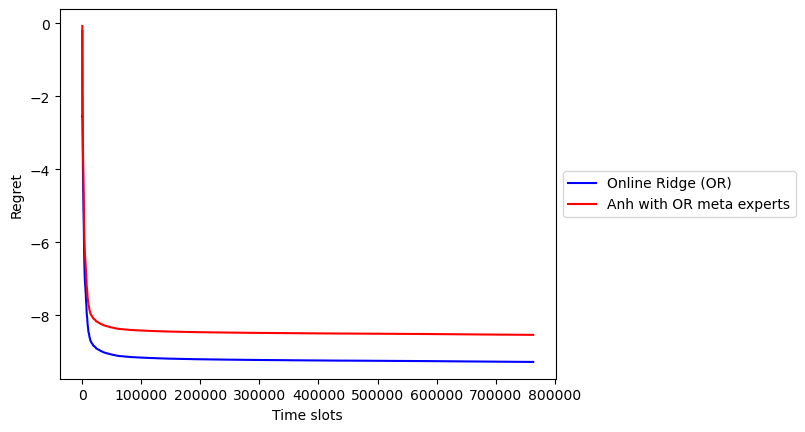

Group number 2, Tg is 1045807 

    oridge end regret -8.561816721809695, Anh end regret -7.8886498523385695, 

    Anh better No 
Oridge regret - Anh regret implementables -0.6731668694711255
Relative difference percent 8.184167499893286


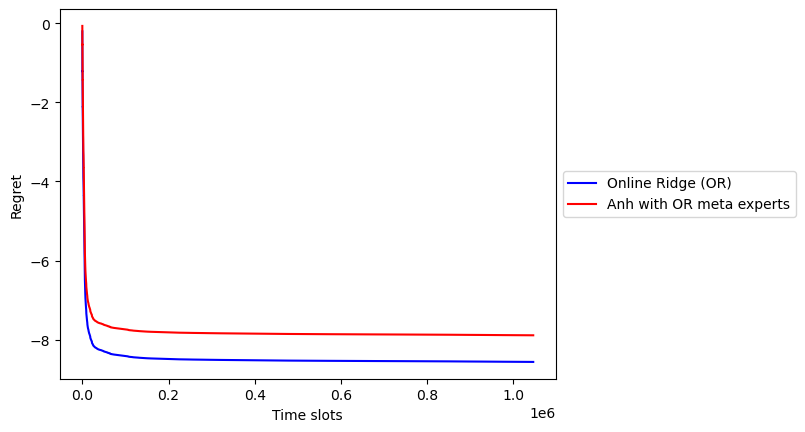

Group number 3, Tg is 136227 

    oridge end regret -10.048499181385127, Anh end regret -9.836434926135725, 

    Anh better No 
Oridge regret - Anh regret implementables -0.21206425524940187
Relative difference percent 2.132913834189626


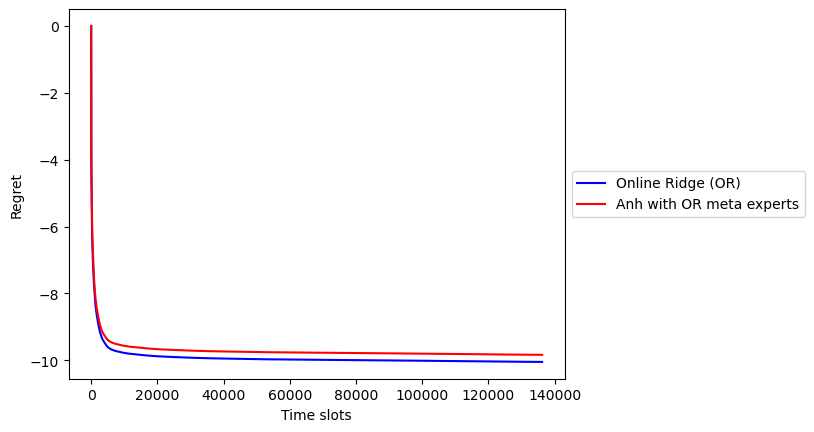

Group number 4, Tg is 14455 

    oridge end regret -8.016413988123634, Anh end regret -7.812102265898293, 

    Anh better No 
Oridge regret - Anh regret implementables -0.20431172222534144
Relative difference percent 2.581565055706685


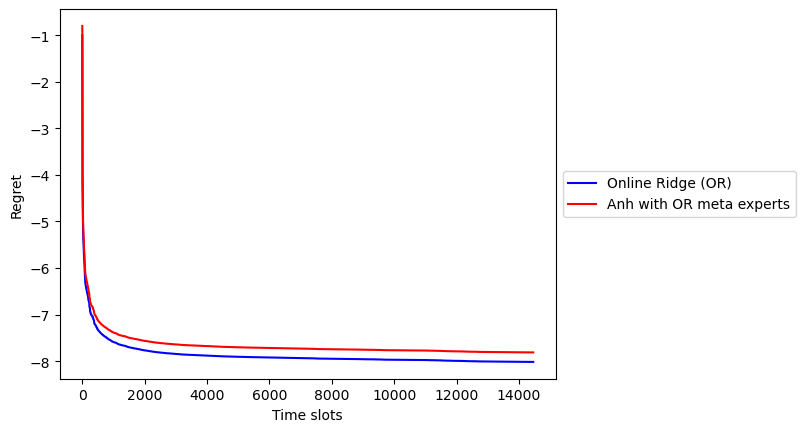

Group number 5, Tg is 726 

    oridge end regret -3.649712762048034, Anh end regret -3.4756445017904025, 

    Anh better No 
Oridge regret - Anh regret implementables -0.17406826025763156
Relative difference percent 4.885881614414962


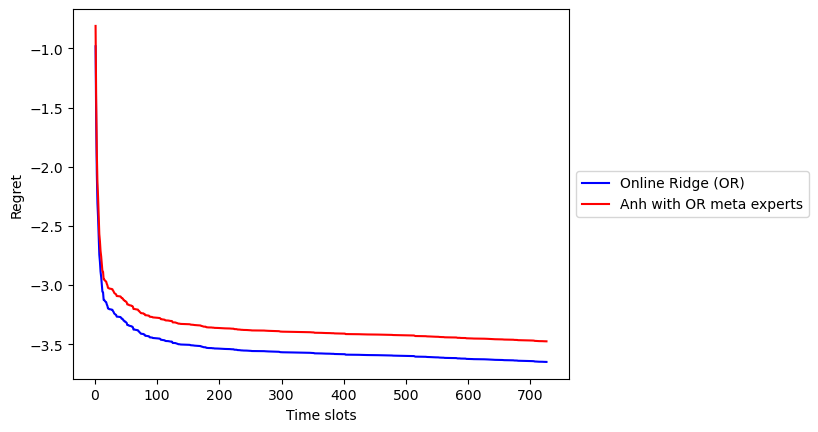

Group number 6, Tg is 2316 

    oridge end regret -5.93967877399293, Anh end regret -5.728458657513274, 

    Anh better No 
Oridge regret - Anh regret implementables -0.2112201164796561
Relative difference percent 3.6204598672161916


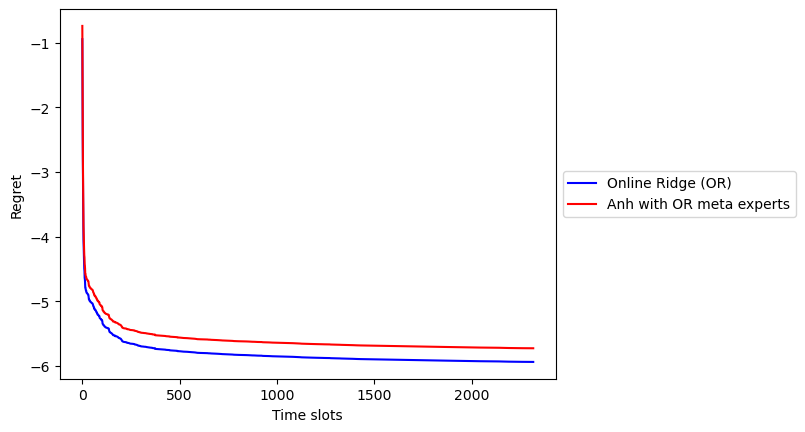

Group number 7, Tg is 100852 

    oridge end regret -10.79997638302802, Anh end regret -10.461013562631551, 

    Anh better No 
Oridge regret - Anh regret implementables -0.3389628203964694
Relative difference percent 3.1885892544309167


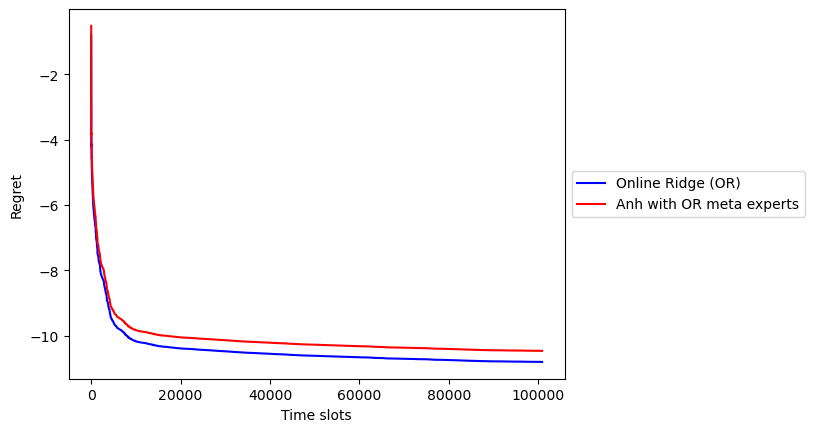

Group number 8, Tg is 2755 

    oridge end regret -6.485697760752041, Anh end regret -6.295909364409974, 

    Anh better No 
Oridge regret - Anh regret implementables -0.1897883963420668
Relative difference percent 2.9697109993069217


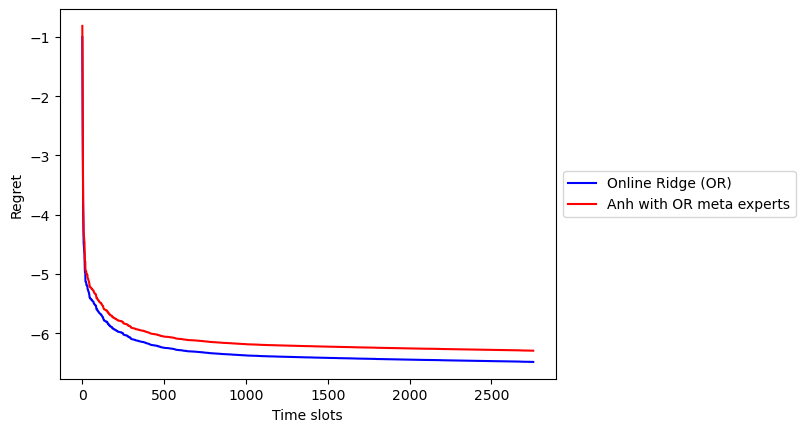

Group number 9, Tg is 97582 

    oridge end regret -10.470761708091107, Anh end regret -10.231072377331305, 

    Anh better No 
Oridge regret - Anh regret implementables -0.23968933075980203
Relative difference percent 2.3156337720683773


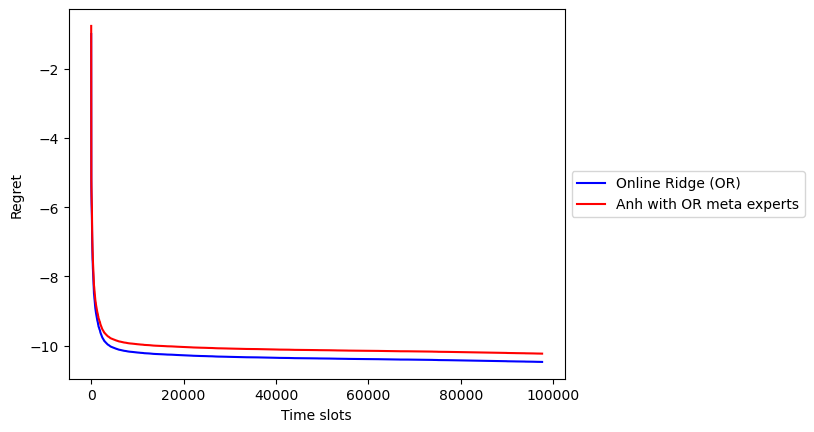

Group number 10, Tg is 168468 

    oridge end regret -11.638704085566792, Anh end regret -11.346933099315201, 

    Anh better No 
Oridge regret - Anh regret implementables -0.29177098625159026
Relative difference percent 2.538724368654809


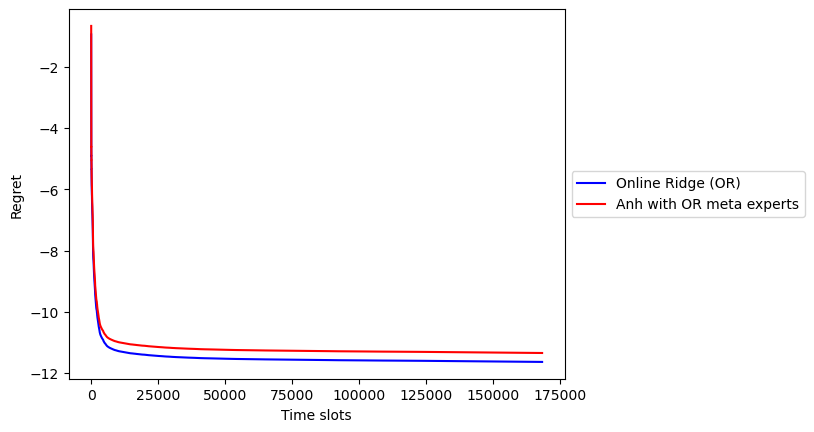

Group number 11, Tg is 1569188 

    oridge end regret -6.079230641558494, Anh end regret -3.5441878841253995, 

    Anh better No 
Oridge regret - Anh regret implementables -2.5350427574330947
Relative difference percent 52.684869740775206


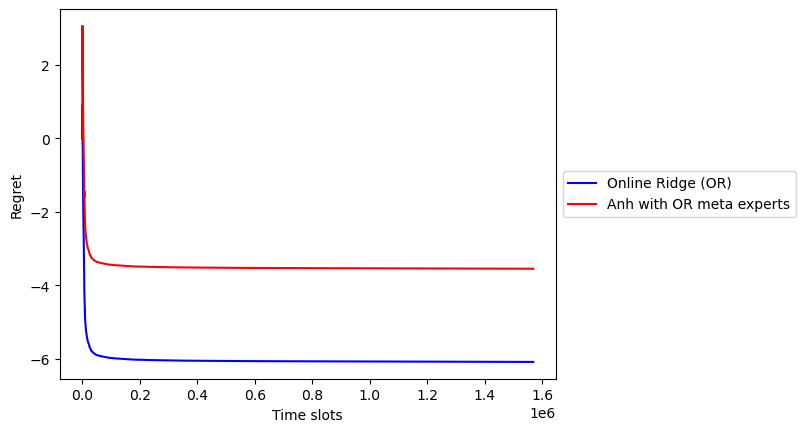

Anh better for 0 out of 12 groups


In [54]:
plot_ORidgevsAnh_together(or_implementable_desc_drop.cumreg_groupwise_oridge, Anh_desc_drop)

# Done w desc,dropped

# Start w asc, dropped

In [24]:
print(cat_cols_sig)
df_oh = one_hot(data_fil, cat_cols_sig)

gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P']


In [25]:
df_oh.drop(cat_cols_sig, axis = 1, inplace=True)

In [26]:
df_oh.sort_values(by=['PINCP'], ascending=True, inplace=True)

In [27]:
df_oh.head()

,WKHP,AGEP,PINCP,OCCP_10,OCCP_20,OCCP_40,OCCP_51,OCCP_52,OCCP_60,OCCP_101,...,MAR_5,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
234219,8.0,61.0,110.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1237948,15.0,17.0,110.0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1011811,4.0,21.0,110.0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
284254,15.0,56.0,110.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
696771,8.0,17.0,110.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [28]:
A_tdf = df_oh[gnames]
A_tdf['alwayson'] = 1
A_t = A_tdf.to_numpy() #ascending inplace different order than 

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_70002/4160201479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1


In [30]:
df_oh.drop(gnames, axis = 1, inplace=True) #this is ascending by PINCP

In [36]:
# for col in df_oh.columns:
#     if 'SEX' in col:
#         print(col)

In [38]:
df_oh_asc_dropped = numeric_scaler(df_oh, df_oh.columns)

In [40]:
df_oh_asc_dropped

,WKHP,AGEP,PINCP,OCCP_10,OCCP_20,OCCP_40,OCCP_51,OCCP_52,OCCP_60,OCCP_101,...,ENG_0,ENG_1,ENG_2,ENG_3,ENG_4,MAR_1,MAR_2,MAR_3,MAR_4,MAR_5
234219,0.071429,0.556962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1237948,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1011811,0.030612,0.050633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284254,0.142857,0.493671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
696771,0.071429,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874887,0.500000,0.278481,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1523250,0.602041,0.392405,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1475552,0.448980,0.607595,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
492215,0.602041,0.379747,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [42]:
N = A_t.shape[1] #  12 groups 11 + 1 always active
d = df_oh_asc_dropped.shape[1]
T = df_oh_asc_dropped.shape[0]
print(N, d, T)

X_dat_asc_dropped = df_oh_asc_dropped.drop('PINCP', axis=1) #dropping the income column
y_dat_asc_dropped = pd.DataFrame(df_oh_asc_dropped['PINCP']) # picking up only the income column for the target


12 887 1569188


In [43]:
# Best sq loss ascending PINCP, dropped sensitive
bls_dropped_asc = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_dropped_asc.update(A_t[t], X_dat_asc_dropped.iloc[[t]], y_dat_asc_dropped.iloc[t])

100%|██████████| 1569188/1569188 [36:10<00:00, 722.85it/s] 


In [44]:
import joblib
bls_dropped_asc.make_all_numpyarr()
joblib.dump(bls_dropped_asc, './onehot_encoded/models/bestsqloss/bls_dropped_asc.pkl')

['./onehot_encoded/models/bestsqloss/bls_dropped_asc.pkl']

In [45]:
# Anh ascending PINCP, dropped sensitive
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_dropped_asc = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_dropped_asc.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_dropped_asc.update_metaexps_loss(A_t[t], X_dat_asc_dropped.iloc[[t]], y_dat_asc_dropped.iloc[t]) # update internal states of the meta-experts

100%|██████████| 1569188/1569188 [37:21<00:00, 699.93it/s]


In [46]:
bls_dropped_asc.cumbestsqloss()
Anh_dropped_asc.build_cumloss_curve(bls_dropped_asc.best_sqloss, A_t)
Anh_dropped_asc.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved


joblib.dump(Anh_dropped_asc, './onehot_encoded/models/Anh/Anh_dropped_asc.pkl')

['./onehot_encoded/models/Anh/Anh_dropped_asc.pkl']

In [47]:
# Oridge implementable dropped asc
or_implementable_dropped_asc = OnlineRidgeImplementable_alwaysactive(X_dat_asc_dropped, y_dat_asc_dropped) # undropped columns
joblib.dump(or_implementable_dropped_asc, './onehot_encoded/models/oridge_implementable/or_implementable_dropped_asc.pkl')

100%|██████████| 1569188/1569188 [13:49<00:00, 1892.72it/s]


['./onehot_encoded/models/oridge_implementable/or_implementable_dropped_asc.pkl']

In [56]:
A_t = np.load('./onehot_encoded/nparrays/A_t_ascPINCP.npy')
Anh_dropped_asc = joblib.load('./onehot_encoded/models/Anh/Anh_dropped_asc.pkl')
bls_dropped_asc = joblib.load('./onehot_encoded/models/bestsqloss/bls_dropped_asc.pkl')
or_implementable_dropped_asc = joblib.load('./onehot_encoded/models/oridge_implementable/or_implementable_dropped_asc.pkl')

In [59]:
bls_dropped_asc.cumbestsqloss()
or_implementable_dropped_asc.fill_subsequence_regrets(A_t, bls_dropped_asc.best_sqloss)

Group number 0, Tg is 805503 

    oridge end regret -0.3613690117189649, Anh end regret -0.01704388018260783, 

    Anh better No 
Oridge regret - Anh regret implementables -0.3443251315363571
Relative difference percent 181.98382713975712


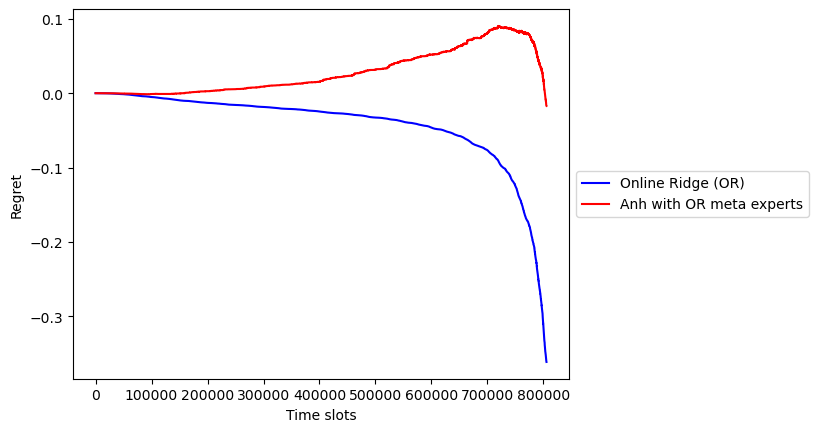

Group number 1, Tg is 763685 

    oridge end regret -0.5848330883068156, Anh end regret -0.3539395891300923, 

    Anh better No 
Oridge regret - Anh regret implementables -0.23089349917672325
Relative difference percent 49.1905026054065


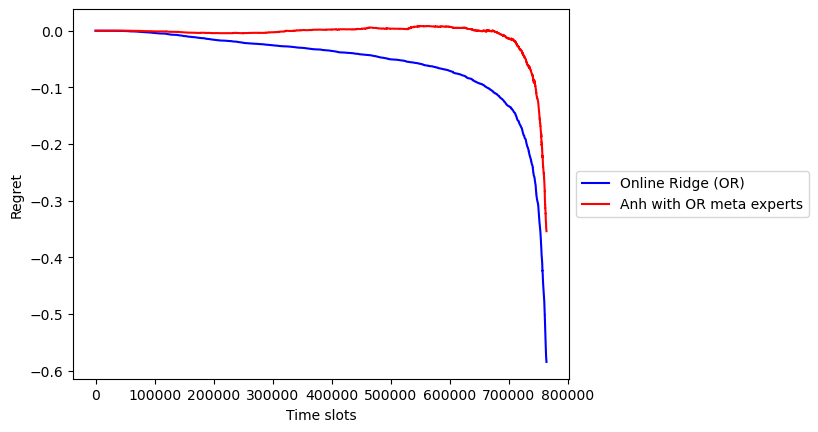

Group number 2, Tg is 1045807 

    oridge end regret -0.39444346183047885, Anh end regret -0.38521853098430936, 

    Anh better No 
Oridge regret - Anh regret implementables -0.009224930846169488
Relative difference percent 2.3663923421135413


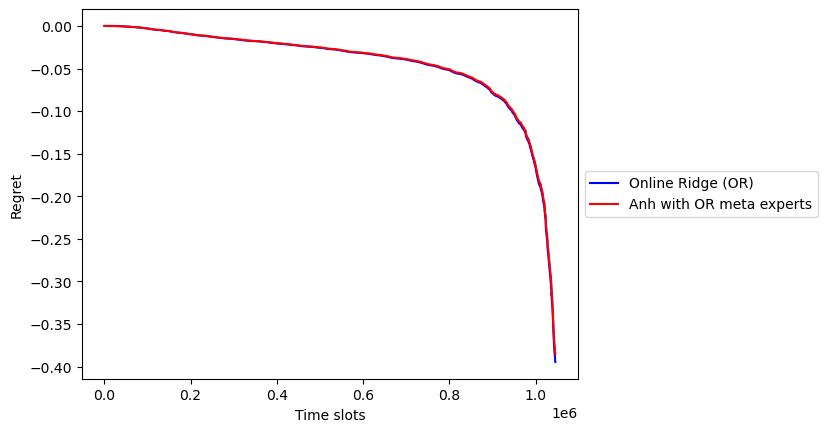

Group number 3, Tg is 136227 

    oridge end regret -0.8158727276213812, Anh end regret -0.776166662655455, 

    Anh better No 
Oridge regret - Anh regret implementables -0.03970606496592621
Relative difference percent 4.988075698180032


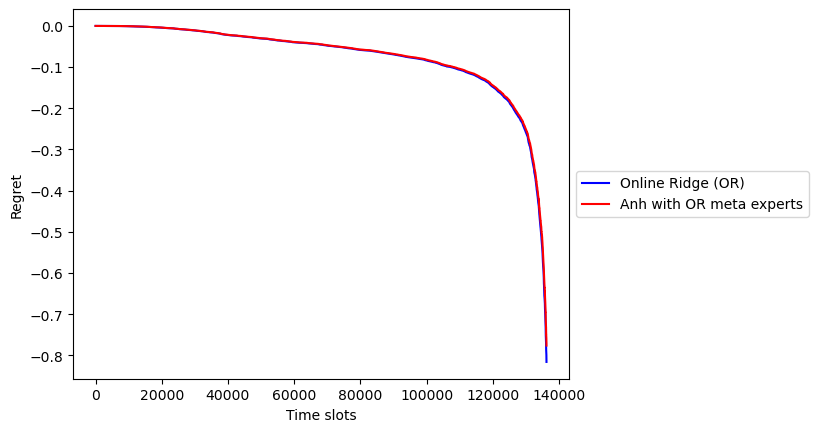

Group number 4, Tg is 14455 

    oridge end regret -1.0148544575628533, Anh end regret -0.9261427480932563, 

    Anh better No 
Oridge regret - Anh regret implementables -0.08871170946959706
Relative difference percent 9.140838452635494


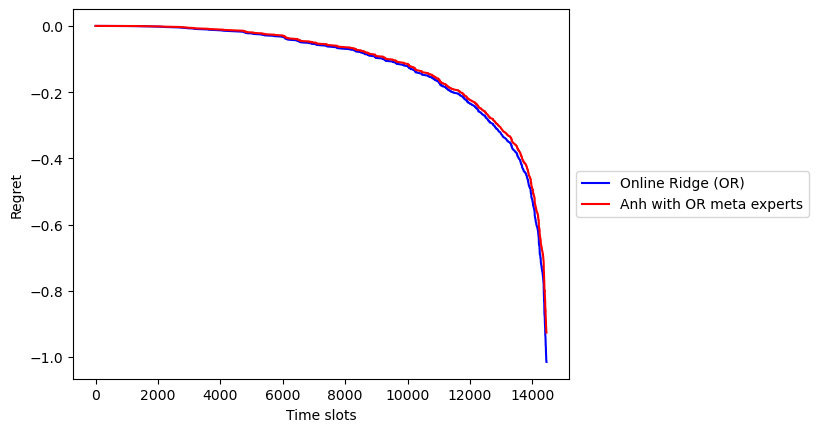

Group number 5, Tg is 726 

    oridge end regret -0.6052762014284456, Anh end regret -0.49597752093697095, 

    Anh better No 
Oridge regret - Anh regret implementables -0.10929868049147468
Relative difference percent 19.849863527672568


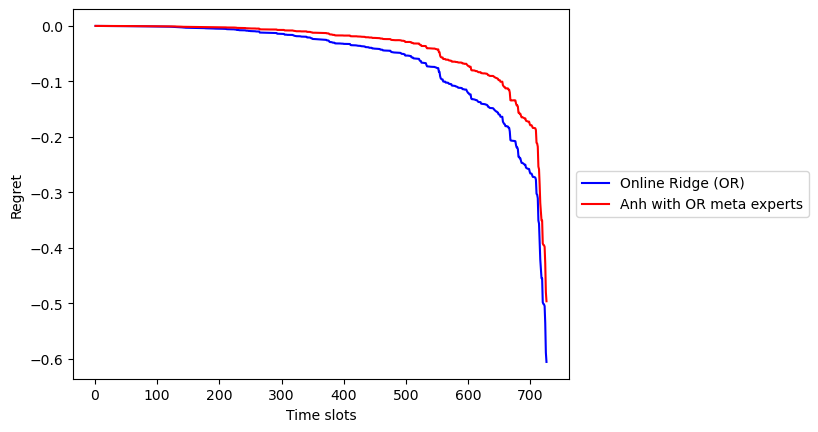

Group number 6, Tg is 2316 

    oridge end regret -0.8452238783743727, Anh end regret -0.7390810211272129, 

    Anh better No 
Oridge regret - Anh regret implementables -0.10614285724715988
Relative difference percent 13.399296723825305


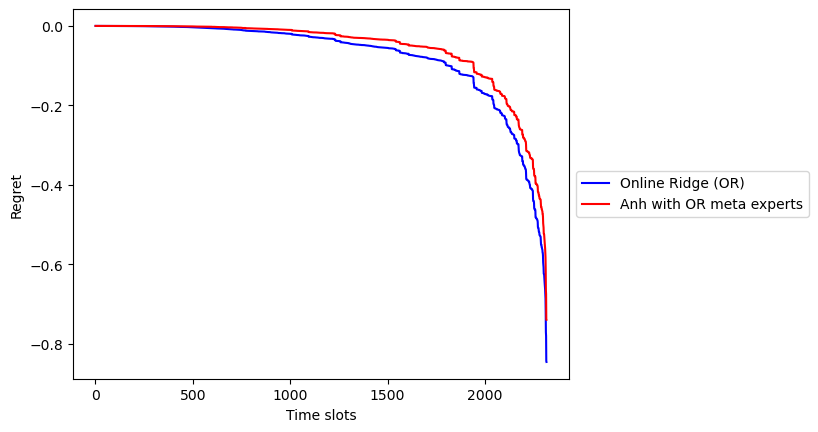

Group number 7, Tg is 100852 

    oridge end regret -1.199770815862342, Anh end regret -1.17120218060723, 

    Anh better No 
Oridge regret - Anh regret implementables -0.028568635255111996
Relative difference percent 2.4098659324801495


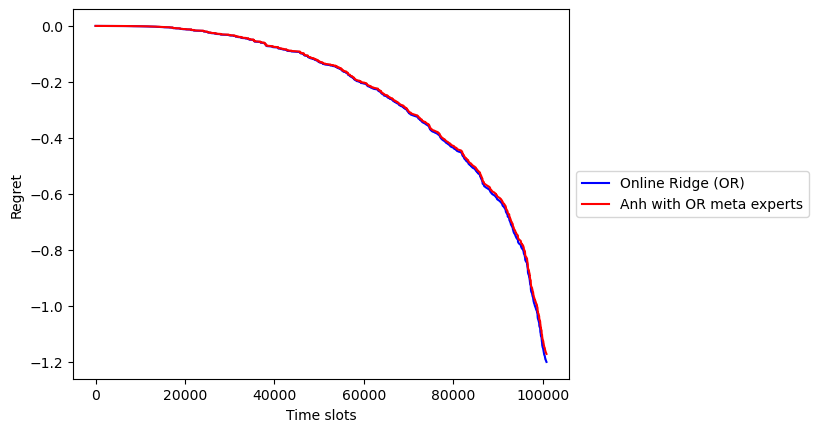

Group number 8, Tg is 2755 

    oridge end regret -1.0108353188990968, Anh end regret -0.905105378059346, 

    Anh better No 
Oridge regret - Anh regret implementables -0.10572994083975085
Relative difference percent 11.036869878863913


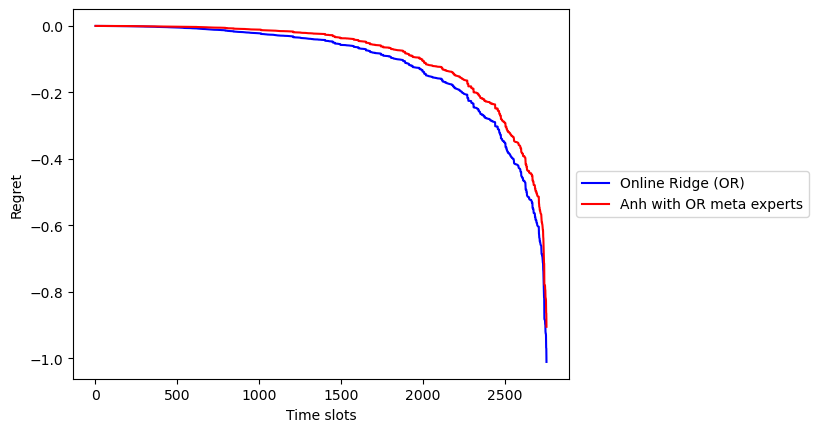

Group number 9, Tg is 97582 

    oridge end regret -0.9912398448390688, Anh end regret -0.9345038364295202, 

    Anh better No 
Oridge regret - Anh regret implementables -0.05673600840954862
Relative difference percent 5.892373835771708


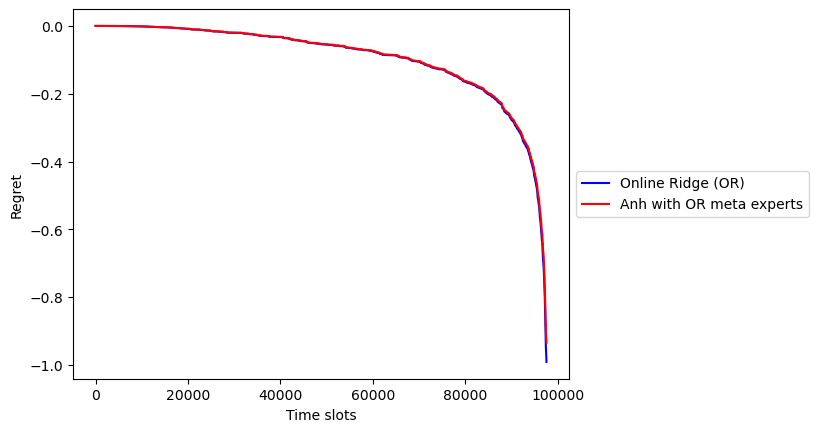

Group number 10, Tg is 168468 

    oridge end regret -0.8383107140102901, Anh end regret -0.8072109108219188, 

    Anh better No 
Oridge regret - Anh regret implementables -0.031099803188371355
Relative difference percent 3.779932480868193


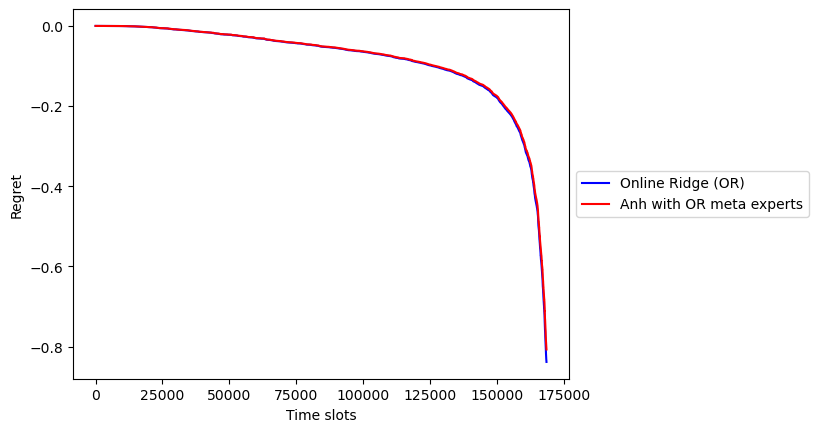

Group number 11, Tg is 1569188 

    oridge end regret -0.2769027785646369, Anh end regret 0.2983158521484098, 

    Anh better No 
Oridge regret - Anh regret implementables -0.5752186307130467
Relative difference percent 200.0


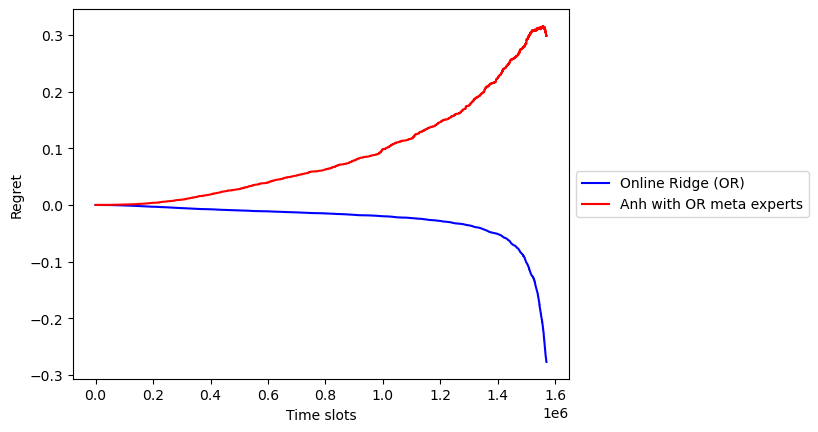

Anh better for 0 out of 12 groups


In [60]:
plot_ORidgevsAnh_together(or_implementable_dropped_asc.cumreg_groupwise_oridge, Anh_dropped_asc)

# Done w asc, dropped

In [62]:
data_fil['ST']

0           1
1           1
2           1
3           1
4           1
           ..
1630162    72
1630163    72
1630164    72
1630165    72
1630166    72
Name: ST, Length: 1569188, dtype: int64

In [66]:
# round robin by states, iid within it
for i in range(1, 73):
    print(i, data_fil['ST'].where(data_fil['ST'] == i).first_valid_index() , data_fil['ST'].where(data_fil['ST'] == i).last_valid_index())


1 0 22732
2 22733 26030
3 None None
4 26031 60394
5 60395 73948
6 73949 266171
7 None None
8 266172 298199
9 298200 317713
10 317714 322346
11 None None
12 322347 419734
13 419735 467373
14 None None
15 467374 475028
16 475029 483757
17 483758 548291
18 548292 582663
19 582664 599835
20 599836 614776
21 614778 636331
22 636332 656152
23 656153 663111
24 663112 696212
25 696213 736575
26 736577 784606
27 784607 815059
28 815060 827559
29 827560 858380
30 858381 863788
31 863789 874464
32 874465 889120
33 889121 896636
34 896637 945443
35 945444 954033
36 954035 1054304
37 1054305 1105526
38 1105527 1109689
39 1109690 1170043
40 1170044 1187445
41 1187446 1208815
42 1208816 1274056
43 None None
44 1274057 1280052
45 1280053 1304633
46 1304634 1309356
47 1309357 1343676
48 1343677 1472263
49 1472264 1489705
50 1489706 1493286
51 1493287 1539214
52 None None
53 1539215 1579168
54 1579169 1586656
55 1586657 1618340
56 1618341 1621284
57 None None
58 None None
59 None None
60 None None
61 No